In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
import seawater as sw
import cartopy.crs as ccrs                   # import projections
import cartopy.feature as cf                 # import features
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import time
import datetime
from datetime import datetime, timedelta, date

import matplotlib as mpl
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

import scipy.io as sp
from scipy import stats, ndimage
from scipy.stats import binned_statistic
from scipy import signal
from scipy.signal import argrelextrema




In [ ]:
rms = lambda x_seq: (sum(x*x for x in x_seq)/len(x_seq))**(1/2)


In [2]:
## Working directories

data_dir = '/Users/sandrac/Documents/projects/AndyJ/data/'
fig_dir_dtpaper ='/Users/sandrac/Documents/projects/AndyJ/DT_paper/plots/'
ll_dir = '/Users/sandrac/Documents/projects/AndyJ/data/lat_lon_maps/'


In [3]:
## Reading  SMODE MATLAB data

flux_mat_contents = sp.loadmat("/Users/sandrac/Documents/projects/AndyJ/data/Matlab/dt_out_alldays_fluxcomp_extras.mat")
print(flux_mat_contents.keys())

dict_keys(['__header__', '__version__', '__globals__', 'Bx', 'Bx2', 'P', 'P_all', 'Q10', 'Q102', 'Qs', 'Qs2', 'Qs2_all', 'Rl', 'Rl_iriss', 'Rnl', 'Rnl2', 'Rnl2_all', 'Rnl_all', 'Rs', 'Rs_all', 'Ss', 'Ss_all', 'cp', 'day', 'dter', 'dter_all', 'ftme', 'ftme_all', 'hbb', 'hbb2', 'heading', 'hlb', 'hlb2', 'hlb2_all', 'hlb_all', 'hsb', 'hsb2', 'hsb2_all', 'hsb_all', 'infile', 'inputfile', 'lat', 'lat_all', 'loadstr', 'lon', 'lon_all', 'outfile', 'outrawfile', 'qbr', 'qbr2', 'qbr2_all', 'qbr_all', 'rain', 'rh', 'rh_iriss', 'rh_iriss_all', 'sigH', 'skin_obs_3', 'skin_obs_3_all', 'skin_obs_9', 'skin_obs_9_all', 't', 't_all', 't_iriss', 'tau', 'tau2', 'tau2_all', 'tau_all', 'tkt', 'tkt_all', 'ts_3', 'ts_3_all', 'ts_9', 'ts_9_all', 'tsnake', 'tsnake_all', 'u', 'u_all', 'usr', 'usr2', 'usr2_all', 'usr_all', 'uy', 'zi', 'zq', 'zq_iriss', 'zrf_q', 'zrf_t', 'zrf_u', 'zt', 'zt_iriss', 'zu'])


In [4]:
## below are the concatenated wind speed and wind direction for studying advection
## Original wind (-180 to 180)

wind_mat_contents = sp.loadmat("/Users/sandrac/Documents/projects/AndyJ/data/Matlab/wind_out_alldays.mat")
print(wind_mat_contents.keys())
wdir = wind_mat_contents.get("wddir_all_u")



dict_keys(['__header__', '__version__', '__globals__', 'day', 'ftme', 'ftme_all_u', 'infile', 'loadstr', 'outrawfile', 'u', 'u_all_u', 'wddir', 'wddir_all_u'])


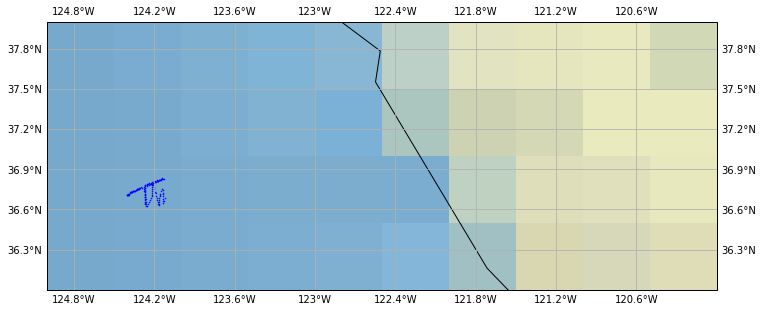

In [5]:
## lat/lon array

# put the data into a pandas DataFrame 
lat=flux_mat_contents.get("lat")
lon=flux_mat_contents.get("lon")
smode_ftme = flux_mat_contents.get("ftme")

nelem = len(np.squeeze(lat))
dumarr3 = np.random.rand(nelem,3)
dumarr3[:,0] = np.squeeze(smode_ftme)
dumarr3[:,1] = np.squeeze(lat)
dumarr3[:,2] = np.squeeze(lon)

df_smode_ll = pd.DataFrame(dumarr3,
    columns = ['ftme','lat','lon']) 
df_smode_ll.dropna(inplace=True)


## plotting global figure
fig = plt.figure(figsize=(12, 9))
cbarkw = dict(shrink=0.5, extend='both',legend=True, legend_kwargs={"frameon": False},)
#cbtitle = (" SST [deg C]")
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude = 135))

cs = ax.coastlines()
gl = ax.gridlines(draw_labels=True)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.top_labels = False
gl.right_labels = False
    
ax.set_extent([-125, -120, 36, 38], crs=ccrs.PlateCarree())  #  (lonw,lone,lats,latn)
ax.stock_img()

### Box with legend
#labels, handles = zip(*[(k, mpatches.Rectangle((0, 0), 1, 1, facecolor=v)) for k,v in lc_colors.items()])
#ax.legend(handles, yrstr, loc=4, framealpha=1, fancybox=True)

im=ax.scatter(df_smode_ll.lon,df_smode_ll.lat,c='b', marker='o', s=.3, transform=ccrs.Geodetic())

#fig.savefig(ll_dir+'map_smode_2022.png',transparent=False, dpi=600, format='png', bbox_inches='tight') 

In [6]:
## Reading S-MODE fluxes 

flux_ftme = flux_mat_contents.get("ftme_all")
lenf = np.size(flux_ftme)
ftr = flux_ftme - np.fix(flux_ftme)
htr = ftr * 24.

flux_qlat = flux_mat_contents.get("hlb_all")
flux_qsen = flux_mat_contents.get("hsb_all")
flux_net_lw = flux_mat_contents.get("Rnl_all")
flux_net = flux_qlat + flux_qsen + flux_net_lw

flux_dtc_qlat = flux_mat_contents.get("hlb2_all")
flux_dtc_qsen = flux_mat_contents.get("hsb2_all")
flux_dtc_netlw = flux_mat_contents.get("Rnl2_all")
flux_dtc_net = flux_dtc_qlat + flux_dtc_qsen + flux_dtc_netlw

flux_wspd = flux_mat_contents.get("u_all")

flux_ustr = flux_mat_contents.get("usr_all")
flux_dtc_ustr = flux_mat_contents.get("usr2_all")

flux_tair = flux_mat_contents.get("t_all")
flux_Patm = flux_mat_contents.get("P_all")
slp = flux_Patm * 293./(293 - 15.5*0.0065)

coare_dt = flux_mat_contents.get('dter_all')

tsnake = flux_mat_contents.get("tsnake_all")
skin3_obs = flux_mat_contents.get("ts_3_all")
skin9_obs = flux_mat_contents.get("ts_9_all")

dt3 = flux_mat_contents.get("skin_obs_3_all")
dt9 = flux_mat_contents.get("skin_obs_9_all")
dtavg = (dt3+dt9)/2.

SW = flux_mat_contents.get("Rs_all")
flag_dn = np.zeros_like(SW)
flag_dn = np.where(SW > 0.0, 1, 0)



dumarr1 = np.random.rand(lenf,16)
dumarr1[:,0] = np.reshape(flux_ftme,lenf)
dumarr1[:,1] = np.reshape(htr,lenf)
dumarr1[:,2] = np.reshape(coare_dt,lenf)
dumarr1[:,3] = np.reshape(dt9,lenf)
dumarr1[:,4] = np.reshape(flux_wspd,lenf)
dumarr1[:,5] = np.reshape(flux_net,lenf)
dumarr1[:,6] = np.reshape(flux_dtc_net,lenf)
dumarr1[:,7] = np.reshape(flag_dn,lenf)
dumarr1[:,8] = np.reshape(skin9_obs,lenf)
dumarr1[:,9] = np.reshape(tsnake,lenf)
dumarr1[:,10] = np.reshape(flux_ustr,lenf)
dumarr1[:,11] = np.reshape(flux_dtc_ustr,lenf)
dumarr1[:,12] = np.reshape(dtavg,lenf)
dumarr1[:,13] = np.reshape(flux_tair,lenf)
dumarr1[:,14] = np.reshape(slp,lenf)
dumarr1[:,15] = np.reshape(wdir,lenf)


dumarrf = dumarr1[~np.isnan(dumarr1).any(axis=1)]

# ftme 	hour 	COARE_DT 	OBS_DT 	true_wspd 	Qnplw 	flag_dn 	tskin9 	tair 	ustr 	qs_qa 	OBS_DT_avg
df_dt = pd.DataFrame(dumarrf,
        columns = ['ftme','hour','COARE_DT','OBS_DT','true_wspd','Qnplw','Qn_dtc','flag_dn',
                    'tskin9','tsnake','ustr','ustr_dtc','OBS_DT_avg','Tair','SLP','wdir'])
        

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in greater


In [8]:

#df_dt

In [9]:
### Correlations time series

lenexp = (df_dt.ftme < 296.)
cor_skn_u = np.corrcoef(df_dt.tskin9[lenexp],df_dt.true_wspd[lenexp])
cor_skn_q = np.corrcoef(df_dt.tskin9[lenexp],df_dt.Qnplw[lenexp])
cor_u_q = np.corrcoef(df_dt.true_wspd[lenexp],df_dt.Qnplw[lenexp])
cor_dto_q = np.corrcoef(df_dt.OBS_DT[lenexp],df_dt.Qnplw[lenexp])
print('Corr sst vs U, all: ',cor_skn_u )
print('Corr sst vs Q, all: ',cor_skn_q )
print('Corr U vs Q, all: ',cor_u_q )
print('Corr DT vs Q, all: ',cor_dto_q )
Qred = df_dt.Qnplw[lenexp]
lenQ = len(Qred)

negQid = (Qred < 0)
negQ = Qred[negQid]
lenQneg = len(negQ)
percetn_Qneg = lenQneg*100/lenQ
print('% Qneg: ',percetn_Qneg)

posQid = (Qred >=0)
posQ = Qred[posQid]
lenQpos = len(posQ)
percetn_Qpos = lenQpos*100/lenQ
print('% Qpos: ',percetn_Qpos)

negQwarmid = (Qred < 0) & (df_dt.OBS_DT[lenexp] > 0)
warmQ  = Qred[negQwarmid]
lenQwarm = len(warmQ )
percent_Qwarm = lenQwarm*100/lenQ
print('% Qwarm: ',percent_Qwarm)

negQuncerid = (Qred < 0) & (df_dt.OBS_DT[lenexp] < 0)
uncerQ  = Qred[negQuncerid]
lenQuncer = len(uncerQ )
percent_Quncer = lenQuncer*100/lenQ
print('% Quncer: ',percent_Quncer)


lenexp2 = (df_dt.ftme < 284.5833333333333334)
cor_skn_u_r = np.corrcoef(df_dt.tskin9[lenexp2],df_dt.true_wspd[lenexp2])
cor_skn_q_r = np.corrcoef(df_dt.tskin9[lenexp2],df_dt.Qnplw[lenexp2])
cor_u_q_r = np.corrcoef(df_dt.true_wspd[lenexp2],df_dt.Qnplw[lenexp2])
cor_dto_q_r = np.corrcoef(df_dt.OBS_DT[lenexp2],df_dt.Qnplw[lenexp2])
print('Corr sst vs U, 284, 2pm: ',cor_skn_u_r )
print('Corr sst vs Q, 284, 2pm: ',cor_skn_q_r )
print('Corr Q vs U, 284, 2pm: ',cor_u_q_r )
print('Corr DT vs Q, 284, 2pm: ',cor_dto_q_r )

Corr sst vs U, all:  [[1.        0.0958444]
 [0.0958444 1.       ]]
Corr sst vs Q, all:  [[1.         0.70502712]
 [0.70502712 1.        ]]
Corr U vs Q, all:  [[1.        0.3648691]
 [0.3648691 1.       ]]
Corr DT vs Q, all:  [[1.         0.09874482]
 [0.09874482 1.        ]]
% Qneg:  35.81833761782348
% Qpos:  64.18166238217653
% Qwarm:  15.5955441302485
% Quncer:  20.22279348757498
Corr sst vs U, 284, 2pm:  [[1.         0.35331924]
 [0.35331924 1.        ]]
Corr sst vs Q, 284, 2pm:  [[1.         0.99154593]
 [0.99154593 1.        ]]
Corr Q vs U, 284, 2pm:  [[1.         0.36547335]
 [0.36547335 1.        ]]
Corr DT vs Q, 284, 2pm:  [[1.         0.55666394]
 [0.55666394 1.        ]]


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
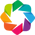

Nelem:  1673


In [12]:
## Figure 3 paper: Plot time series

import hvplot.pandas
import datashader as ds
from bokeh.transform import factor_cmap, factor_mark
import holoviews as hv

# setting bokeh as backend
hv.extension('bokeh')

# going to use show() to open plot in browser
from bokeh.plotting import show

ftmef = np.array(df_dt.ftme)
wndf = np.array(df_dt.true_wspd)
qnetf = np.array(df_dt.Qnplw)
tskinf = np.array(df_dt.tskin9)
tsnakef = np.array(df_dt.tsnake)
#dto = np.array(df_dt.OBS_DT)
dto = np.array(df_dt.OBS_DT_avg)
wdirf = np.array(df_dt.wdir)

tt = ftmef.argsort()[:len(ftmef)]
ftmef = ftmef[tt]
wndf = wndf[tt]
qnetf = qnetf[tt]
tskinf = tskinf[tt]
tsnakef = tsnakef[tt]
dtobs = tskinf - tsnakef
dtof = dto[tt]*(-1)
wdirf = wdirf[tt]

nelem = len(np.squeeze(ftmef))
print('Nelem: ',nelem)
dumarr0 = np.random.rand(nelem,7)
dumarr0[:,0] = np.squeeze(ftmef)
dumarr0[:,1] = np.squeeze(wndf)
dumarr0[:,2] = np.squeeze(qnetf)
dumarr0[:,3] = np.squeeze(tskinf) 
dumarr0[:,4] = np.squeeze(tsnakef)
#dumarr0[:,5] = np.squeeze(dtobs)
#dumarr0[:,5] = np.squeeze(dtof)
dumarr0[:,5] = np.squeeze(signal.savgol_filter(dtof,13,3))
#dumarr0[:,6] = np.squeeze(wdirf)
dumarr0[:,6] = np.squeeze(signal.savgol_filter(wdirf,7,3))

df_met = pd.DataFrame(dumarr0,
    columns = ['DOY 2022','Wind Speed','Net Heat Flux','Skin SST','SST Depth', 'Observed ΔTcool', 'Wind Direction'])
    

#plot = df_met.hvplot.line('DOY 2022','Wind Speed', xlim=(284,296),ylim=(0,12), c='k')
#plot = df_met.hvplot.line('DOY 2022','Wind Direction', xlim=(284,296),ylim=(-180,180), c='k')
#plot = df_met.hvplot.line('DOY 2022','Net Heat Flux', xlim=(284,296),ylim=(-100,200), c='k')
#plot = df_met.hvplot.line('DOY 2022','Skin SST', xlim=(284,296),ylim=(13,20), c='k')
plot = df_met.hvplot.line('DOY 2022','Observed ΔTcool', xlim=(284,296),ylim=(-0.3,0.3), c='k')
#plot = df_met.hvplot.line('DOY 2022',['Tskin','Tsnake'], xlim=(284,300),ylim=(12,20))
#plot = df_met.hvplot.line('DOY 2022',['Tskin','Wspd'], xlim=(284,300),ylim=(0,20))
show(hv.render(plot))


#figname ='/Users/sandrac/Documents/projects/AndyJ/DT_paper/plots_paper/SMODE_Qnet_timeseries.png'
#figname ='/Users/sandrac/Documents/projects/AndyJ/DT_paper/plots_paper/SMODE_Wspd_timeseries.png'
#figname ='/Users/sandrac/Documents/projects/AndyJ/DT_paper/plots_paper/SMODE_Wdir_timeseries.png'
#figname ='/Users/sandrac/Documents/projects/AndyJ/DT_paper/plots_paper/SMODE_Tskin_timeseries.png'
#figname ='/Users/sandrac/Documents/projects/AndyJ/DT_paper/plots_paper/SMODE_DTobs_timeseries.png'
#figname ='/Users/sandrac/Documents/projects/AndyJ/DT_paper/plots_paper/SMODE_TskinTsnake_timeseries.png'
#hv.save(plot, figname, fmt='png', dpi=120)


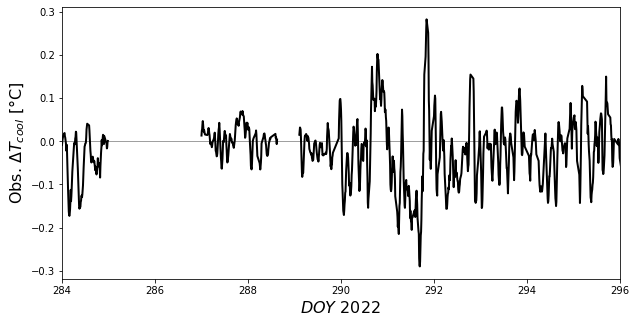

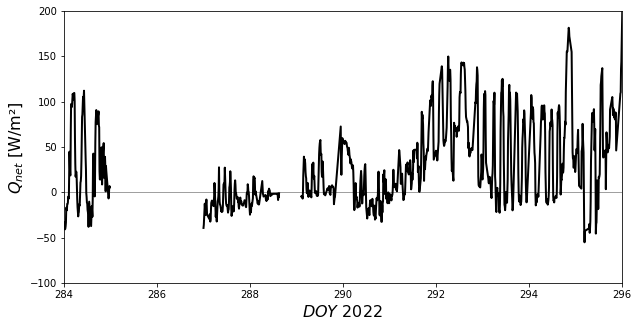

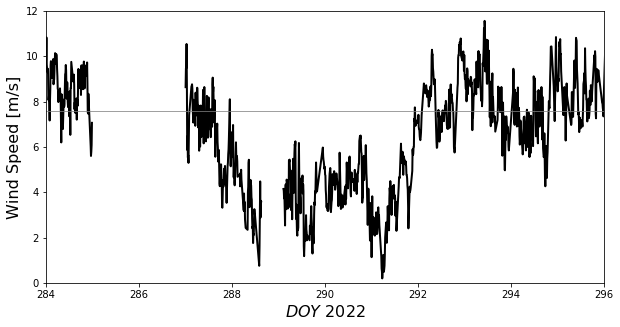

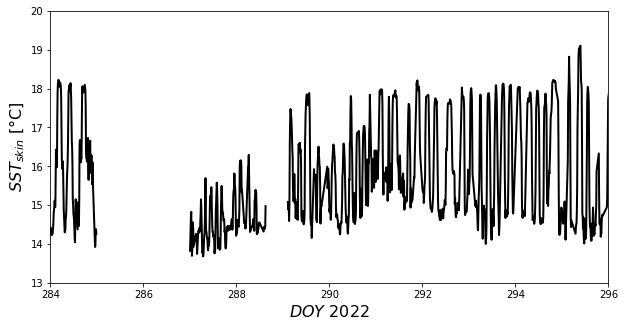

In [13]:
# Figure 3 paper: Repeat time series without the line for Nan; request reviewer

dtosm = signal.savgol_filter(dtof,13,3)
wdirsm = signal.savgol_filter(wdirf,7,3)

bins_ft = np.arange(283,303,1)   
tzeroarr = np.zeros(len(bins_ft))
avgwind = np.full(len(bins_ft),7.6)

dumarr02 = np.full((nelem+4,7),np.nan)

dumarr02[0:132,0] = np.squeeze(ftmef[0:132])
dumarr02[135:335,0] = np.squeeze(ftmef[133:333])
dumarr02[337:1675,0] = np.squeeze(ftmef[334:1672])

dumarr02[0:132,1] = np.squeeze(wndf[0:132])
dumarr02[135:335,1] = np.squeeze(wndf[133:333])
dumarr02[337:1675,1] = np.squeeze(wndf[334:1672])

dumarr02[0:132,2] = np.squeeze(qnetf[0:132])
dumarr02[135:335,2] = np.squeeze(qnetf[133:333])
dumarr02[337:1675,2] = np.squeeze(qnetf[334:1672])

dumarr02[0:132,3] = np.squeeze(tskinf[0:132])
dumarr02[135:335,3] = np.squeeze(tskinf[133:333])
dumarr02[337:1675,3] = np.squeeze(tskinf[334:1672])

dumarr02[0:132,4] = np.squeeze(tsnakef[0:132])
dumarr02[135:335,4] = np.squeeze(tsnakef[133:333])
dumarr02[337:1675,4] = np.squeeze(tsnakef[334:1672])

dumarr02[0:132,5] = np.squeeze(dtosm[0:132])
dumarr02[135:335,5] = np.squeeze(dtosm[133:333])
dumarr02[337:1675,5] = np.squeeze(dtosm[334:1672])

dumarr02[0:132,6] = np.squeeze(wdirsm[0:132])
dumarr02[135:335,6] = np.squeeze(wdirsm[133:333])
dumarr02[337:1675,6] = np.squeeze(wdirsm[334:1672])


fig = plt.figure(figsize = (10,5))
plt.plot(bins_ft,tzeroarr, color='grey',linewidth=1, alpha=0.75)
plt.plot(dumarr02[:,0], dumarr02[:,5], color='k',linewidth=2,label="")
plt.ylabel('Obs. $ΔT_{cool}$ [$\u00B0$C]', fontsize = 16)
plt.xlabel("$DOY$ 2022",fontsize=16)
plt.margins(x=0)  
plt.xlim([284,296])
fig_fname = '/Users/sandrac/Documents/projects/AndyJ/DT_paper/plots/SMODE_ts_dto_revised.png'
#plt.savefig(fig_fname, dpi=300, transparent=False, format='png', bbox_inches='tight')
plt.draw()
plt.show()

fig = plt.figure(figsize = (10,5))
plt.plot(bins_ft,tzeroarr, color='grey',linewidth=1, alpha=0.75)
plt.plot(dumarr02[:,0], dumarr02[:,2], color='k',linewidth=2,label="")
plt.ylabel('$Q_{net}$ [W/m\u00b2]', fontsize = 16)
plt.xlabel("$DOY$ 2022",fontsize=16)
plt.margins(x=0)  # no padding
plt.ylim([-100,200])
plt.xlim([284,296])
fig_fname = '/Users/sandrac/Documents/projects/AndyJ/DT_paper/plots/SMODE_ts_qn_revised.png'
#plt.savefig(fig_fname, dpi=300, transparent=False, format='png', bbox_inches='tight')
plt.draw()
plt.show()

fig = plt.figure(figsize = (10,5))
plt.plot(dumarr02[:,0], dumarr02[:,1], color='k',linewidth=2,label="")
plt.plot(bins_ft,avgwind, color='grey',linewidth=1, alpha=0.75)
plt.ylabel("Wind Speed [m/s]",fontsize=16)
plt.xlabel("$DOY$ 2022",fontsize=16)
plt.margins(x=0)  # no padding
plt.ylim([0,12])
plt.xlim([284,296])
fig_fname = '/Users/sandrac/Documents/projects/AndyJ/DT_paper/plots/SMODE_ts_wnd_revised.png'
#plt.savefig(fig_fname, dpi=300, transparent=False, format='png', bbox_inches='tight')
plt.draw()
plt.show()

fig = plt.figure(figsize = (10,5))
plt.plot(dumarr02[:,0], dumarr02[:,3], color='k',linewidth=2,label="")
plt.ylabel('$SST_{skin}$ [$\u00B0$C]', fontsize = 16)
plt.xlabel("$DOY$ 2022",fontsize=16)
plt.margins(x=0)  # no padding
plt.ylim([13,20])
plt.xlim([284,296])
fig_fname = '/Users/sandrac/Documents/projects/AndyJ/DT_paper/plots/SMODE_ts_tskn_revised.png'
#plt.savefig(fig_fname, dpi=300, transparent=False, format='png', bbox_inches='tight')
plt.draw()
plt.show()

In [34]:
# Variables

wnd = df_dt.true_wspd
wdir = df_dt.wdir
dto = df_dt.OBS_DT*(-1)
dtm = df_dt.COARE_DT*(-1)
err = dtm - dto
err_frac = err/dto

donlon_smode =  -0.14-0.30*np.exp(-0.27*wnd)
err_donlon = donlon_smode - dto

qnet_s = df_dt.Qnplw
qnet_c = df_dt.Qn_dtc
qnet_err = qnet_c - qnet_s

tskn = df_dt.tskin9
tsnk = df_dt.tsnake
tair = df_dt.Tair
ts_ta = df_dt.tskin9 - df_dt.Tair

tskin = df_dt.tskin9
tsnake = df_dt.tsnake

bins_dt = np.arange(-1,1,0.1)
bins_qp = np.arange(-3,3,0.25)

bins_u = np.arange(0,20,1)
uzeroarr = np.zeros(20)

bins_q = np.arange(-100,600,25)   
qzeroarr = np.zeros(len(bins_q))


## Donlon model
rn = range(200)
wndarr= np.array(rn)
wndarr = wndarr/10.
donlon = -0.14-0.30*np.exp(-0.27*wndarr)


tskin = df_dt.tskin9
tsnake = df_dt.tsnake
coare_dt_cool = df_dt.COARE_DT
tskin_coare = tsnake - coare_dt_cool

err_tskin = tskin_coare -tskin




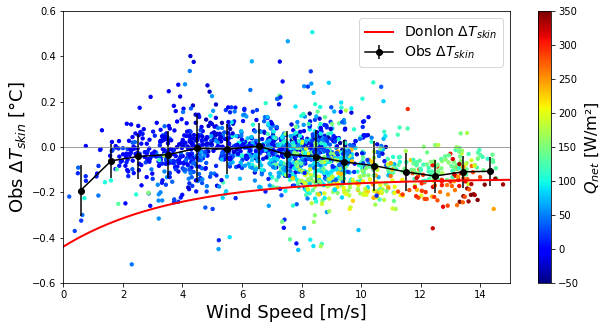

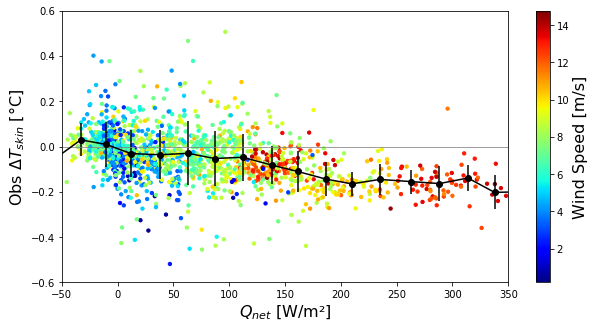

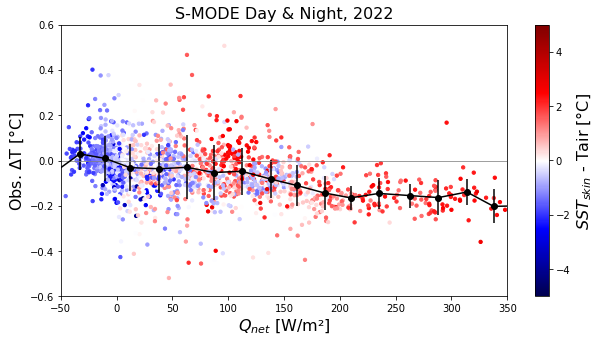

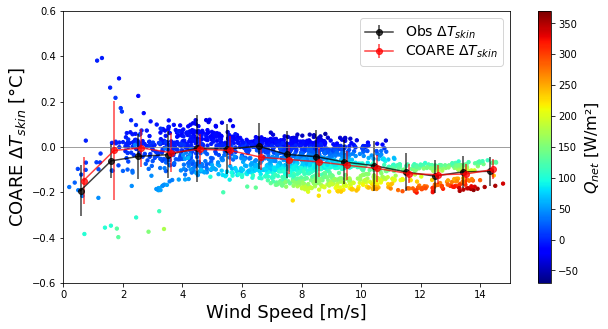

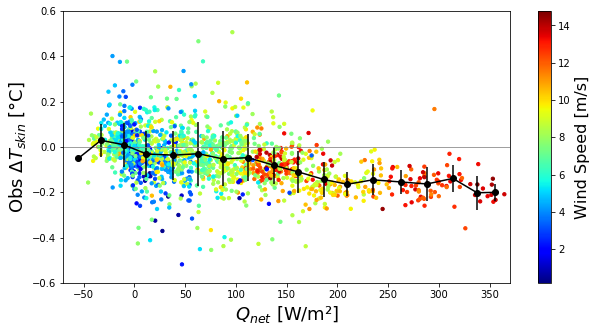

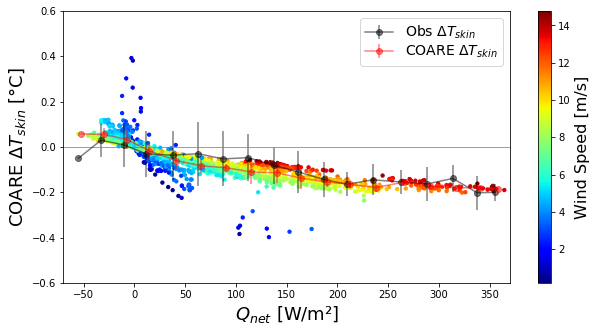

In [16]:
## Figure 8 paper

wndarr= np.array(rn)
wndarr = wndarr/10.

bins_q = np.arange(-100,600,25)   
qzeroarr = np.zeros(len(bins_q))

dtof = dto[~np.isnan(dto)]
dtmf = dtm[~np.isnan(dto)]
wndf = wnd[~np.isnan(dto)]
qnet_sf = qnet_s[~np.isnan(dto)]
qnet_c_wf = qnet_c[~np.isnan(dto)]

## Binned averages
bin_ctr_w_dto, _, _ = stats.binned_statistic(wndf, wndf, statistic='mean', bins=bins_u)
bin_avg_w_dto, _, _ = stats.binned_statistic(wndf, dtof, statistic='mean', bins=bins_u)
bin_std_w_dto, _, _ = stats.binned_statistic(wndf, dtof, statistic='std', bins=bins_u)

bin_ctr_w_dtm, _, _ = stats.binned_statistic(wndf, wndf, statistic='mean', bins=bins_u)
bin_avg_w_dtm, _, _ = stats.binned_statistic(wndf, dtmf, statistic='mean', bins=bins_u)
bin_std_w_dtm, _, _ = stats.binned_statistic(wndf, dtmf, statistic='std', bins=bins_u)

bin_ctr_q_dto_s, _, _ = stats.binned_statistic(qnet_sf, qnet_sf, statistic='mean', bins=bins_q)
bin_avg_q_dto_s, _, _ = stats.binned_statistic(qnet_sf, dtof, statistic='mean', bins=bins_q)
bin_std_q_dto_s, _, _ = stats.binned_statistic(qnet_sf, dtof, statistic='std', bins=bins_q)

bin_ctr_q_dtm_s, _, _ = stats.binned_statistic(qnet_sf, qnet_sf, statistic='mean', bins=bins_q)
bin_avg_q_dtm_s, _, _ = stats.binned_statistic(qnet_sf, dtmf, statistic='mean', bins=bins_q)
bin_std_q_dtm_s, _, _ = stats.binned_statistic(qnet_sf, dtmf, statistic='std', bins=bins_q)
        
bin_ctr_q_dto_cw, _, _ = stats.binned_statistic(qnet_c_wf, qnet_c_wf, statistic='mean', bins=bins_q)
bin_avg_q_dto_cw, _, _ = stats.binned_statistic(qnet_c_wf, dtof, statistic='mean', bins=bins_q)
bin_std_q_dto_cw, _, _ = stats.binned_statistic(qnet_c_wf, dtof, statistic='std', bins=bins_q)



fig = plt.figure(figsize = (10,5))
fig = plt.scatter(wnd, dto, c=qnet_s, cmap='jet', marker='o', s=11)
plt.plot(bins_u,uzeroarr, color='grey',linewidth=1, alpha=0.75)
plt.errorbar(bin_ctr_w_dto, bin_avg_w_dto, bin_std_w_dto,fmt="o-", color="k", label="Obs $ΔT_{skin}$" )
plt.plot(wndarr,donlon, color='r',linewidth=2,label="Donlon $ΔT_{skin}$")
plt.xlabel('Wind Speed [m/s]',fontsize=18)
plt.ylabel("Obs $ΔT_{skin}$ [$\u00B0$C]",fontsize=18)
#plt.title("S-MODE Day & Night, 2022",fontsize=16)
plt.margins(x=0)  
plt.legend(loc='upper right',fontsize=14,labelspacing=0.2)
plt.xlim([0,15])
plt.ylim([-0.6,0.6])
plt.clim([-50,350])
cb = plt.colorbar()
cb.set_label('$Q_{net}$ [W/m\u00b2]',fontsize=16)
fig_fname = fig_dir_dtpaper + 'SMODE_dto_wspd_cQn_rev.png'
#plt.savefig(fig_fname, dpi=300, transparent=False, format='png', bbox_inches='tight')
plt.draw()
plt.show()

fig = plt.figure(figsize = (10,5))
fig = plt.scatter(qnet_s,dto, c=wnd, cmap='jet', marker='o', s=11)
plt.plot(bins_q,qzeroarr, color='grey', linewidth=1, alpha=0.75)
plt.errorbar(bin_ctr_q_dto_s, bin_avg_q_dto_s, bin_std_q_dto_s,fmt="o-", color="k")
plt.xlabel('$Q_{net}$ [W/m\u00b2]', fontsize = 16)
plt.ylabel("Obs $ΔT_{skin}$ [$\u00B0$C]",fontsize=16)
#plt.title("S-MODE Day & Night, 2022",fontsize=16)
plt.margins(x=0)  
plt.xlim([-50,350])
plt.ylim([-0.6,0.6])
cb = plt.colorbar()
cb.set_label('Wind Speed [m/s]',fontsize=16)
fig_fname = fig_dir_dtpaper + 'SMODE_dto_qn_cU_rev.png'
#plt.savefig(fig_fname, dpi=300, transparent=False, format='png', bbox_inches='tight')
plt.draw()
plt.show()

fig = plt.figure(figsize = (10,5))
fig = plt.scatter(qnet_s,dto, c=ts_ta, cmap='seismic', marker='o', s=11)
plt.plot(bins_q,qzeroarr, color='grey', linewidth=1, alpha=0.75)
plt.errorbar(bin_ctr_q_dto_s, bin_avg_q_dto_s, bin_std_q_dto_s,fmt="o-", color="k")
plt.xlabel('$Q_{net}$ [W/m\u00b2]', fontsize = 16)
plt.ylabel("Obs. ΔT [$\u00B0$C]",fontsize=16)
plt.title("S-MODE Day & Night, 2022",fontsize=16)
plt.margins(x=0)  
plt.xlim([-50,350])
plt.ylim([-0.6,0.6])
plt.clim([-5,5])
cb = plt.colorbar()
cb.set_label('$SST_{skin}$ - Tair [$\u00B0$C]',fontsize=16)
fig_fname = fig_dir_dtpaper + 'SMODE_dto_qn_cTsTa.png'
#plt.savefig(fig_fname, dpi=300, transparent=False, format='png', bbox_inches='tight')
plt.draw()
plt.show()


fig = plt.figure(figsize = (10,5))
fig = plt.scatter(wnd, dtm, c=qnet_s, cmap='jet', marker='o', s=11)
plt.plot(bins_u,uzeroarr, color='grey',linewidth=1, alpha=0.75)
plt.errorbar(bin_ctr_w_dto, bin_avg_w_dto, bin_std_w_dto,fmt="o-", color="k", alpha=0.75, label="Obs $ΔT_{skin}$")
plt.errorbar(bin_ctr_w_dtm+0.1, bin_avg_w_dtm, bin_std_w_dtm,fmt="o-", color="r", alpha=0.75, label="COARE $ΔT_{skin}$")
plt.xlabel('Wind Speed [m/s]',fontsize=18)
plt.ylabel("COARE $ΔT_{skin}$ [$\u00B0$C]",fontsize=18)
#plt.title("S-MODE 2022",fontsize=16)
plt.margins(x=0)  
plt.legend(loc='upper right',fontsize=14,labelspacing=0.2)
plt.xlim([0,15])
plt.ylim([-0.6,0.6])
plt.clim([-70,370])
cb = plt.colorbar()
cb.set_label('$Q_{net}$ [W/m\u00b2]',fontsize=16)
fig_fname = fig_dir_dtpaper + 'SMODE_dtm_wspd_cQn_rev.png'
#plt.savefig(fig_fname, dpi=300, transparent=False, format='png', bbox_inches='tight')
plt.draw()
plt.show()

fig = plt.figure(figsize = (10,5))
fig = plt.scatter(qnet_s,dto, c=wnd, cmap='jet', marker='o', s=11)
plt.plot(bins_q,qzeroarr, color='grey', linewidth=1, alpha=0.75)
plt.errorbar(bin_ctr_q_dto_s, bin_avg_q_dto_s, bin_std_q_dto_s,fmt="o-", color="k")
plt.xlabel('$Q_{net}$ [W/m\u00b2]', fontsize = 18)
plt.ylabel("Obs $ΔT_{skin}$ [$\u00B0$C]",fontsize=18)
#plt.title("S-MODE 2022",fontsize=16)
plt.margins(x=0)  
plt.xlim([-70,370])
plt.ylim([-0.6,0.6])
cb = plt.colorbar()
cb.set_label('Wind Speed [m/s]',fontsize=16)
fig_fname = fig_dir_dtpaper + 'SMODE_dto_qn_cU_rev.png'
#plt.savefig(fig_fname, dpi=300, transparent=False, format='png', bbox_inches='tight')
plt.draw()
plt.show()

fig = plt.figure(figsize = (10,5))
fig = plt.scatter(qnet_s,dtm, c=wnd, cmap='jet', marker='o', s=11)
plt.plot(bins_q,qzeroarr, color='grey', linewidth=1, alpha=0.75)
plt.errorbar(bin_ctr_q_dto_s, bin_avg_q_dto_s, bin_std_q_dto_s,fmt="o-", color="k", alpha=0.5, label="Obs $ΔT_{skin}$")
plt.errorbar(bin_ctr_q_dtm_s+3, bin_avg_q_dtm_s, bin_std_q_dtm_s,fmt="o-", color="r", alpha=0.5, label="COARE $ΔT_{skin}$")
plt.xlabel('$Q_{net}$ [W/m\u00b2]', fontsize = 18)
plt.ylabel("COARE $ΔT_{skin}$ [$\u00B0$C]",fontsize=18)
#plt.title("S-MODE 2022",fontsize=16)
plt.legend(loc='upper right',fontsize=14,labelspacing=0.2)
plt.margins(x=0)  # no padding
plt.xlim([-70,370])
plt.ylim([-0.6,0.6])
cb = plt.colorbar()
cb.set_label('Wind Speed [m/s]',fontsize=16)
fig_fname = fig_dir_dtpaper + 'SMODE_dtm_qn_cU_rev.png'
#plt.savefig(fig_fname, dpi=300, transparent=False, format='png', bbox_inches='tight')
plt.draw()
plt.show()



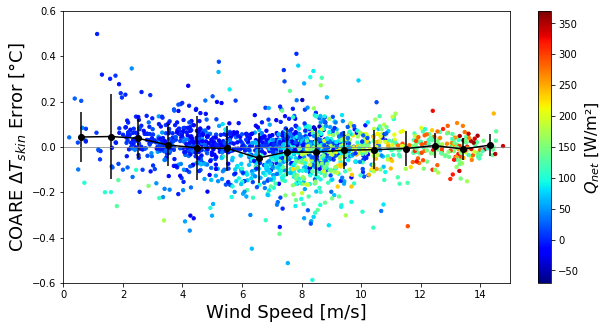

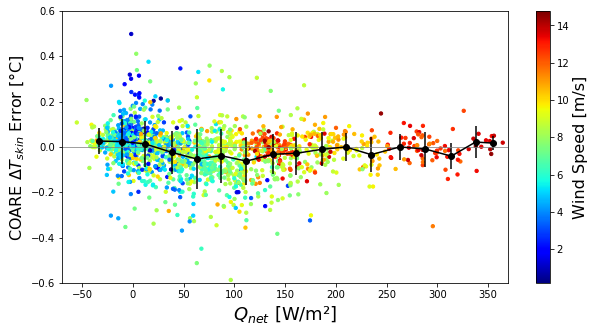

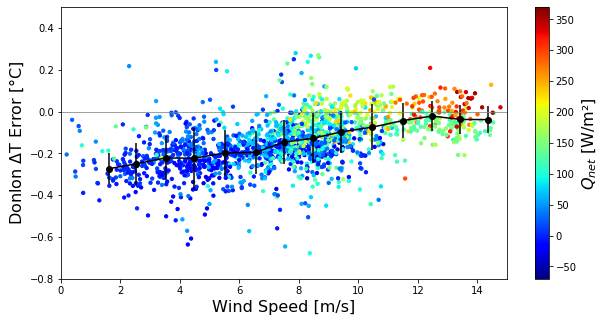

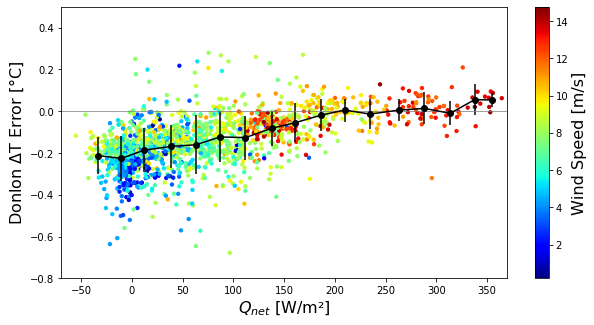

In [15]:
#Plots:  paper Fig 12 Errors

bin_ctr_w_dtcer, _, _ = stats.binned_statistic(wnd, wnd, statistic='mean', bins=bins_u)
bin_avg_w_dtcer, _, _ = stats.binned_statistic(wnd, err, statistic='mean', bins=bins_u)
bin_std_w_dtcer, _, _ = stats.binned_statistic(wnd, err, statistic='std', bins=bins_u)

fig = plt.figure(figsize = (10,5))
fig = plt.scatter(wnd, err, c=qnet_s, cmap='jet', marker='o', s=11)
plt.plot(bins_u,uzeroarr, color='grey',linewidth=1, alpha=0.75)
plt.errorbar(bin_ctr_w_dtcer, bin_avg_w_dtcer, bin_std_w_dtcer,fmt="o-", color="k")
plt.xlabel('Wind Speed [m/s]',fontsize=18)
plt.ylabel("COARE $ΔT_{skin}$ Error [$\u00B0$C]",fontsize=18)
plt.margins(x=0)  
plt.xlim([0,15])
plt.ylim([-0.6,0.6])
plt.clim([-70,370])
cb = plt.colorbar()
cb.set_label('$Q_{net}$ [W/m\u00b2]',fontsize=16)
fig_fname = '/Users/sandrac/Documents/projects/AndyJ/DT_paper/plots_paper/SMODE_dterr_wspd_cQs_bin_rev.png'
#plt.savefig(fig_fname, dpi=300, transparent=False, format='png', bbox_inches='tight')
plt.draw()
plt.show()

bins_qr = np.arange(-50,600,25)
bin_ctr_q_dtcer, _, _ = stats.binned_statistic(qnet_s, qnet_s, statistic='mean', bins=bins_qr)
bin_avg_q_dtcer, _, _ = stats.binned_statistic(qnet_s, err, statistic='mean', bins=bins_qr)
bin_std_q_dtcer, _, _ = stats.binned_statistic(qnet_s, err, statistic='std', bins=bins_qr)

fig = plt.figure(figsize = (10,5))
fig = plt.scatter(qnet_s,err, c=wnd, cmap='jet', marker='o', s=11)
plt.plot(bins_q,qzeroarr, color='grey', linewidth=1, alpha=0.75)
plt.errorbar(bin_ctr_q_dtcer, bin_avg_q_dtcer, bin_std_q_dtcer,fmt="o-", color="k")
plt.xlabel('$Q_{net}$ [W/m\u00b2]', fontsize = 18)
plt.ylabel("COARE $ΔT_{skin}$ Error [$\u00B0$C]",fontsize=16)
plt.margins(x=0)  
plt.xlim([-70,370])
plt.ylim([-0.6,0.6])
cb = plt.colorbar()
cb.set_label('Wind Speed [m/s]',fontsize=16)
fig_fname = '/Users/sandrac/Documents/projects/AndyJ/DT_paper/plots_paper/SMODE_dterr_qnets_cU_bin_rev.png'
#plt.savefig(fig_fname, dpi=300, transparent=False, format='png', bbox_inches='tight')
plt.draw()
plt.show()


## with binned plot
#donlon_smode =  -0.14-0.30*np.exp(-0.27*wnd)
#err_donlon = donlon_smode - dto
bins_ur = np.arange(1,20,1)
bin_ctr_w_dtder, _, _ = stats.binned_statistic(wnd, wnd, statistic='mean', bins=bins_ur)
bin_avg_w_dtder, _, _ = stats.binned_statistic(wnd, err_donlon, statistic='mean', bins=bins_ur)
bin_std_w_dtder, _, _ = stats.binned_statistic(wnd, err_donlon, statistic='std', bins=bins_ur)

fig = plt.figure(figsize = (10,5))
fig = plt.scatter(wnd, err_donlon, c=qnet_s, cmap='jet', marker='o', s=11)
plt.plot(bins_u,uzeroarr, color='grey',linewidth=1, alpha=0.75)
plt.errorbar(bin_ctr_w_dtder, bin_avg_w_dtder, bin_std_w_dtder,fmt="o-", color="k")
plt.xlabel('Wind Speed [m/s]',fontsize=16)
#plt.ylabel("ΔT Error = Donlon ΔT - Obs ΔT  [$\u00B0$C]",fontsize=16)
plt.ylabel("Donlon ΔT Error [$\u00B0$C]",fontsize=16)
plt.margins(x=0)  
plt.xlim([0,15])
plt.ylim([-0.8,0.5])
plt.clim([-70,370])
cb = plt.colorbar()
cb.set_label('$Q_{net}$ [W/m\u00b2]',fontsize=16)
fig_fname = '/Users/sandrac/Documents/projects/AndyJ/DT_paper/plots_paper/SMODE_dterrdonlon_wspd_cqn_bin.png'
#plt.savefig(fig_fname, dpi=300, transparent=False, format='png', bbox_inches='tight')
plt.draw()
plt.show()

bin_ctr_q_dtder, _, _ = stats.binned_statistic(qnet_s, qnet_s, statistic='mean', bins=bins_qr)
bin_avg_q_dtder, _, _ = stats.binned_statistic(qnet_s, err_donlon, statistic='mean', bins=bins_qr)
bin_std_q_dtder, _, _ = stats.binned_statistic(qnet_s, err_donlon, statistic='std', bins=bins_qr)

fig = plt.figure(figsize = (10,5))
fig = plt.scatter(qnet_s,err_donlon, c=wnd, cmap='jet', marker='o', s=11)
plt.plot(bins_q,qzeroarr, color='grey', linewidth=1, alpha=0.75)
plt.errorbar(bin_ctr_q_dtder, bin_avg_q_dtder, bin_std_q_dtder,fmt="o-", color="k")
plt.xlabel('$Q_{net}$ [W/m\u00b2]', fontsize = 16)
plt.ylabel("Donlon ΔT Error [$\u00B0$C]",fontsize=16)
plt.margins(x=0)  
plt.xlim([-70,370])
plt.ylim([-0.8,0.5])
cb = plt.colorbar()
cb.set_label('Wind Speed [m/s]',fontsize=16)
fig_fname = '/Users/sandrac/Documents/projects/AndyJ/DT_paper/plots_paper/SMODE_dterrdonlon_Qs_cU_bin.png'
#plt.savefig(fig_fname, dpi=300, transparent=False, format='png', bbox_inches='tight')
plt.draw()
plt.show()



Night mean, std dif, var, rms, rho:  0.01241650618548329 0.10428759241222416 0.010875901931138193 0.10502414749471833 0.4631374702552983


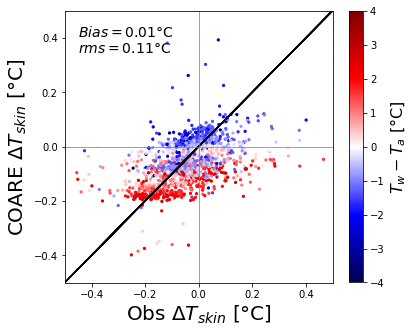

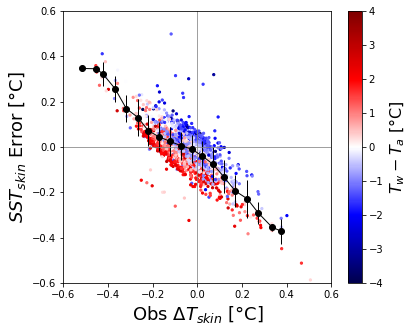

In [21]:
## Fig. 10a paper

rms = lambda x_seq: (sum(x*x for x in x_seq)/len(x_seq))**(1/2)


xn=np.squeeze(np.array(dto))
yn=np.squeeze(np.array(dtm))
idx = pd.notnull(xn)
xn = xn[idx]
yn = yn[idx]


xyndif = xn - yn
mun = np.mean(xyndif)
sigman = np.std(xyndif)
varn = np.var(xyndif)
rmsn = rms(xyndif)
xn_ts = pd.Series(xn)
yn_ts = pd.Series(yn)
rn = xn_ts.corr(yn_ts)

print('Night mean, std dif, var, rms, rho: ', mun, sigman, varn, rmsn, rn)


textstr_dt = '\n'.join((
     r'$Bias=%.2f$' % (mun, ) +'$\u00B0$C',
     r'$rms=%.2f$' % (rmsn, ) +'$\u00B0$C'))


fig = plt.figure(figsize = (6,5))
plt.text(-0.45, 0.45, textstr_dt, fontsize=14,verticalalignment='top')
fig = plt.scatter(dto,dtm, c=ts_ta, cmap='seismic', marker='o', s=5)
plt.plot(dto,dto, c='k')
plt.plot([-0.5,0.5],[0.0,0.0],color='grey',linewidth=1, alpha=0.75)
plt.plot([0.0,0.0],[-0.5,0.5],color='grey',linewidth=1, alpha=0.75)
plt.xlabel('Obs $ΔT_{skin}$ [$\u00B0$C]', fontsize = 20)
plt.ylabel("COARE $ΔT_{skin}$ [$\u00B0$C]",fontsize=20)
#plt.title('S-MODE 2022, Night',fontsize=16)
#plt.title('Night Only',fontsize=16)
plt.margins(x=0)  # no padding
plt.xlim([-0.5,0.5])
plt.ylim([-0.5,0.5])
plt.clim(-4,4)  ### Forces zero in the middle of the color bar
cb = plt.colorbar()
cb.set_label('$T_{w} - T_{a}$ [$\u00B0$C]',fontsize=16)
fig_fname = '/Users/sandrac/Documents/projects/AndyJ/DT_paper/plots_paper/SMODE_dto_dtm_ctsta_rev.png'
#plt.savefig(fig_fname, dpi=300, transparent=False, format='png', bbox_inches='tight')
plt.draw()
plt.show()

## Tskin Error
bins_ts = np.arange(10,20,0.5)
bins_dt = np.arange(-0.65,0.45,0.05)   
err_tskin = tskin_coare-tskin
yer = err_tskin 
yerf = yer[~np.isnan(yer)]
dtof = dto[~np.isnan(yer)]

bin_ctr_dto_sster, _, _ = stats.binned_statistic(dtof, dtof, statistic='mean', bins=bins_dt)
bin_avg_dto_sster, _, _ = stats.binned_statistic(dtof, yerf, statistic='mean', bins=bins_dt)
bin_std_dto_sster, _, _ = stats.binned_statistic(dtof, yerf, statistic='std', bins=bins_dt)


fig = plt.figure(figsize = (6,5))
fig = plt.scatter(dto, err_tskin, c=ts_ta, cmap='seismic', marker='o', s=5)
plt.errorbar(bin_ctr_dto_sster, bin_avg_dto_sster, bin_std_dto_sster,fmt="o-", color="k",linewidth=1,label="")
plt.plot([-0.65,0.65],[0.0,0.0],color='grey',linewidth=1, alpha=0.75)
plt.plot([0.0,0.0],[-0.65,0.65],color='grey',linewidth=1, alpha=0.75)
plt.xlabel('Obs $ΔT_{skin}$ [$\u00B0$C]', fontsize = 18)
plt.ylabel("$SST_{skin}$ Error [$\u00B0$C]",fontsize=18)
plt.margins(x=0)  
plt.xlim([-0.6,0.6])
plt.ylim([-0.6,0.6])
plt.clim(-4,4)  ### Forces zero in the middle of the color bar
cb = plt.colorbar()
cb.set_label('$T_{w} - T_{a}$ [$\u00B0$C]',fontsize=16)
fig_fname = '/Users/sandrac/Documents/projects/AndyJ/DT_paper/plots_paper/SMODE_dto_errSSTskn_ctsta_rev.png'
#plt.savefig(fig_fname, dpi=300, transparent=False, format='png', bbox_inches='tight')
plt.draw()
plt.show()


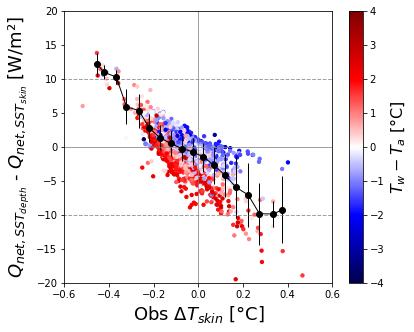

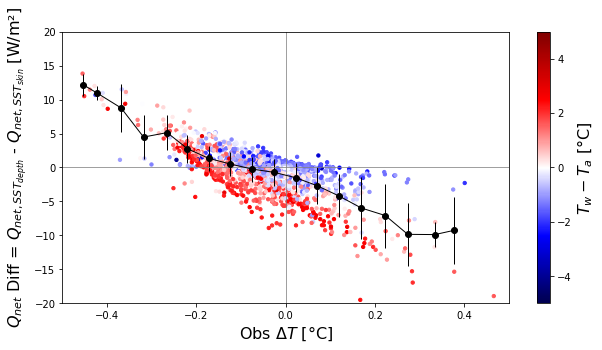

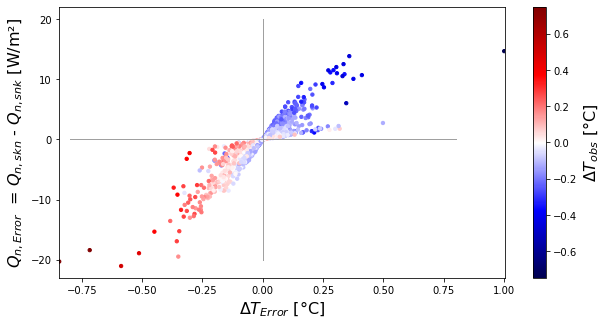

In [22]:
## Paper Fig 10b

tskin = df_dt.tskin9
tsnake = df_dt.tsnake
#ts_ta = df_dt.tskin9 - df_dt.Tair
#wnd = df_dt.true_wspd


# Removing 4 points causing trouble
test4 = (dto >= -0.26) | (dto < -0.26) & (qnet_err >= 4) & (ts_ta <= 0) |  (ts_ta  > 0) 
tstan = ts_ta[test4]
qnerrn = qnet_err[test4]
dton = dto[test4]
wspdn = wnd[test4]

yer2 = qnerrn
yer2f = qnerrn[~np.isnan(yer2)]
dto2f = dton[~np.isnan(yer2)]
tstan2 = tstan[~np.isnan(yer2)]
wspdn2f = wspdn[~np.isnan(yer2)]

bins_dt = np.arange(-0.5,0.45,0.05)
bin_ctr_dto_qer_f, _, _ = stats.binned_statistic(dto2f, dto2f, statistic='mean', bins=bins_dt)
bin_avg_dto_qer_f, _, _ = stats.binned_statistic(dto2f, yer2f, statistic='mean', bins=bins_dt)
bin_std_dto_qer_f, _, _ = stats.binned_statistic(dto2f, yer2f, statistic='std', bins=bins_dt)


fig = plt.figure(figsize = (6,5))
fig = plt.scatter(dton, qnerrn, c=tstan, cmap='seismic', marker='o', s=11)
plt.plot([0.0,0.0],[-20,20],color='grey',linewidth=1, alpha=0.75)
plt.plot([-5,5],[0.0,0.0],color='grey',linewidth=1, alpha=0.75)
plt.plot([-5,5],[10.0,10.0],color='grey',linewidth=1, alpha=0.75,linestyle='--')
plt.plot([-5,5],[-10.0,-10.0],color='grey',linewidth=1, alpha=0.75,linestyle='--')
plt.errorbar(bin_ctr_dto_qer_f, bin_avg_dto_qer_f, bin_std_dto_qer_f,fmt="o-", color="k",linewidth=1,label="")
plt.xlabel('Obs $ΔT_{skin}$ [$\u00B0$C]',fontsize=18)
plt.ylabel('$Q_{net,SST_{depth}}$ - $Q_{net,SST_{skin}}$ [W/m\u00b2]',fontsize=18)
plt.margins(x=0)  
plt.ylim([-20,20])
plt.xlim([-0.6,0.6])
plt.clim(-4,4)  
cb = plt.colorbar()
cb.set_label('$T_{w} - T_{a}$ [$\u00B0$C]',fontsize=16)
fig_fname = fig_dir_dtpaper + 'SMODE_qerr_dto_ctsta_sqr_rev.png'
#plt.savefig(fig_fname, dpi=300, transparent=False, format='png', bbox_inches='tight')
plt.draw()
plt.show()

yer = qnet_err
yerf = yer[~np.isnan(yer)]
dtof = dto[~np.isnan(yer)]
dtmf = dtm[~np.isnan(yer)]
qnsf = qnet_s[~np.isnan(yer)]

bins_dt = np.arange(-0.5,0.45,0.05)
bin_ctr_dto_qer, _, _ = stats.binned_statistic(dtof, dtof, statistic='mean', bins=bins_dt)
bin_avg_dto_qer, _, _ = stats.binned_statistic(dtof, yerf, statistic='mean', bins=bins_dt)
bin_std_dto_qer, _, _ = stats.binned_statistic(dtof, yerf, statistic='std', bins=bins_dt)

bin_ctr_dtm_qer, _, _ = stats.binned_statistic(dtmf, dtmf, statistic='mean', bins=bins_dt)
bin_avg_dtm_qer, _, _ = stats.binned_statistic(dtmf, yerf, statistic='mean', bins=bins_dt)
bin_std_dtm_qer, _, _ = stats.binned_statistic(dtmf, yerf, statistic='std', bins=bins_dt)

## Against Tskin
bins_q = np.arange(-100,425,25)   
qzeroarr = np.zeros(len(bins_q))
bin_ctr_qs_qer, _, _ = stats.binned_statistic(qnsf, qnsf, statistic='mean', bins=bins_q)
bin_avg_qs_qer, _, _ = stats.binned_statistic(qnsf, yerf, statistic='mean', bins=bins_q)
bin_std_qs_qer, _, _ = stats.binned_statistic(qnsf, yerf, statistic='std', bins=bins_q)


fig = plt.figure(figsize = (10,5))
fig = plt.scatter(dto, qnet_err, c=ts_ta, cmap='seismic', marker='o', s=11)
plt.plot([0.0,0.0],[-20,20],color='grey',linewidth=1, alpha=0.75)
plt.plot([-5,5],[0.0,0.0],color='grey',linewidth=1, alpha=0.75)
plt.errorbar(bin_ctr_dto_qer, bin_avg_dto_qer, bin_std_dto_qer,fmt="o-", color="k",linewidth=1,label="")
plt.xlabel('Obs $ΔT$ [$\u00B0$C]',fontsize=16)
plt.ylabel('$Q_{net}$ Diff = $Q_{net,SST_{depth}}$ - $Q_{net,SST_{skin}}$ [W/m\u00b2]',fontsize=16)
plt.margins(x=0)  
plt.ylim([-20,20])
plt.xlim([-0.5,0.5])
plt.clim(-5,5)  ### Forces zero in the middle of the color bar
cb = plt.colorbar()
cb.set_label('$T_{w} - T_{a}$ [$\u00B0$C]',fontsize=16)
fig_fname = fig_dir_dtpaper + 'SMODE_qerr_dto_cdterr.png'
#plt.savefig(fig_fname, dpi=300, transparent=False, format='png', bbox_inches='tight')
plt.draw()
plt.show()


fig = plt.figure(figsize = (10,5))
fig = plt.scatter(err, qnet_err, c=dto, cmap='seismic', marker='o', s=11)
plt.plot([0.0,0.0],[-20,20],color='grey',linewidth=1, alpha=0.75)
plt.plot([-0.8,0.8],[0.0,0.0],color='grey',linewidth=1, alpha=0.75)
plt.xlabel('$ΔT_{Error}$ [$\u00B0$C]',fontsize=16)
plt.ylabel('$Q_{n,Error}$  = $Q_{n,skn}$ - $Q_{n,snk}$ [W/m\u00b2]',fontsize=16)
plt.margins(x=0)  # no padding
plt.clim(-0.75,0.75)  ### Forces zero in the middle of the color bar
cb = plt.colorbar()
cb.set_label('$ΔT_{obs}$ [$\u00B0$C]',fontsize=16)
fig_fname = fig_dir_dtpaper + 'SMODE_qerr_dterr_cdto.png'
#plt.savefig(fig_fname, dpi=300, transparent=False, format='png', bbox_inches='tight')
plt.draw()
plt.show()



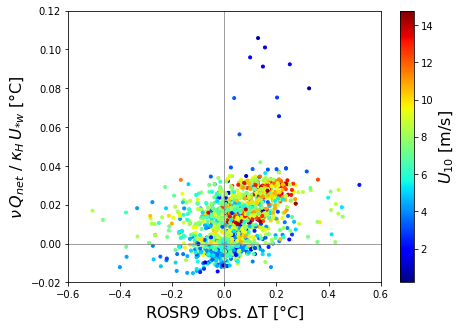

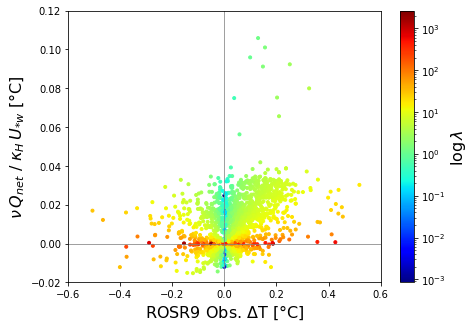

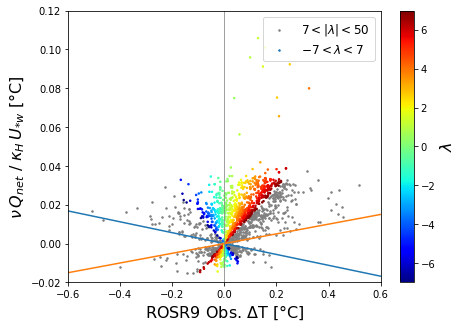

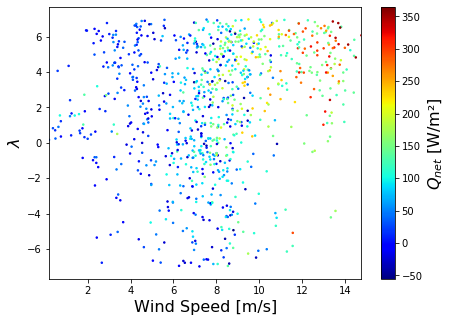

In [35]:
qnet = df_dt.Qnplw
ustr_w = df_dt.ustr*np.sqrt(1.2/1022)
dtobs = df_dt.OBS_DT
q_over_u = qnet*0.000001/ustr_w/0.6
ts_ta = df_dt.tskin9 - tair
lambda_dt = dtobs/q_over_u


mask_lambda = (lambda_dt >= -7) & (lambda_dt <= 7)
mask_grey = (lambda_dt > -50) & (lambda_dt < -7) | (lambda_dt > 7) & (lambda_dt < 50)

lambda_dtc = lambda_dt[mask_lambda]
q_over_u_dtc = q_over_u[mask_lambda]
dtobs_dtc = dtobs[mask_lambda]
wspd_dtc = df_dt.true_wspd[mask_lambda]
qnet_dtc = qnet[mask_lambda]

lambda_dtg = lambda_dt[mask_grey]
q_over_u_dtg = q_over_u[mask_grey]
dtobs_dtg = dtobs[mask_grey]
wspd_dtg = df_dt.true_wspd[mask_grey]
qnet_dtg = qnet[mask_grey]

fig, ax = plt.subplots(figsize=(7,5))
fig = ax.scatter(dtobs,q_over_u, c=df_dt.true_wspd,cmap='jet',marker='o', s=9)
plt.plot([0.0,0.0],[-0.6,0.6],color='grey', linewidth=1, alpha=0.75)
plt.plot([-0.6,0.6],[0.0,0.0],color='grey', linewidth=1,  alpha=0.75)
plt.xlabel('ROSR9 Obs. ΔT [$\u00B0$C]', fontsize = 16)
plt.ylabel(r"$\nu \/ Q_{net}$ / $\kappa_{H} \/ U_{*w}$" " [$\u00B0$C]",fontsize=16)
plt.margins(x=0)  # no padding
plt.xlim([-0.6,0.6])
plt.ylim([-0.02,0.12])
cb = plt.colorbar(fig, ax=ax)
cb.set_label('$U_{10}$ [m/s]' ,fontsize=16)
#fig_fname = fig_dir+'qoveru_dtobs_cu.png'
#plt.savefig(fig_fname, dpi=300, transparent=False, format='png', bbox_inches='tight')
plt.draw()
plt.show()

fig, ax = plt.subplots(figsize=(7,5))
fig = ax.scatter(dtobs,q_over_u, c=np.abs(lambda_dt),cmap='jet',norm=mpl.colors.LogNorm(),marker='o', s=9)
plt.plot([0.0,0.0],[-0.6,0.6],color='grey', linewidth=1, alpha=0.75)
plt.plot([-0.6,0.6],[0.0,0.0],color='grey', linewidth=1,  alpha=0.75)
plt.xlabel('ROSR9 Obs. ΔT [$\u00B0$C]', fontsize = 16)
plt.ylabel(r"$\nu \/ Q_{net}$ / $\kappa_{H} \/ U_{*w}$" " [$\u00B0$C]",fontsize=16)
plt.margins(x=0)  # no padding
plt.xlim([-0.6,0.6])
plt.ylim([-0.02,0.12])
cb = plt.colorbar(fig, ax=ax)
cb.set_label('$\log \/ \lambda$' ,fontsize=16)
#fig_fname = fig_dir+'qoveru_dtobs_cloglambda.png'
#plt.savefig(fig_fname, dpi=300, transparent=False, format='png', bbox_inches='tight')
plt.draw()
plt.show()

xn =np.arange(-0.6,0.65,0.05)
yn = -0.25*xn
yn = -0.028*xn
yp = 0.025*xn
fig, ax = plt.subplots(figsize=(7,5))
fig = ax.scatter(dtobs_dtg,q_over_u_dtg, c='grey', marker='.', s=9, label="$7 < |\lambda| < 50$")
fig = ax.scatter(dtobs_dtc,q_over_u_dtc, c=lambda_dtc,cmap='jet', marker='.', s=9, label="$-7 < \lambda < 7$")
ax.legend(fontsize = 12, loc='upper right')
plt.plot(xn,yn)
plt.plot(xn,yp)
plt.plot([0.0,0.0],[-0.5,0.5],color='grey', linewidth=1, alpha=0.75)
plt.xlabel('ROSR9 Obs. ΔT [$\u00B0$C]', fontsize = 16)
plt.ylabel(r"$\nu \/ Q_{net}$ / $\kappa_{H} \/ U_{*w}$" " [$\u00B0$C]",fontsize=16)
plt.margins(x=0)  # no padding
plt.xlim([-0.6,0.6])
plt.ylim([-0.02,0.12])
cb = plt.colorbar(fig, ax=ax)
cb.set_label('$\lambda$' ,fontsize=16)
#fig_fname = fig_dir+'qoveru_dtobs_clambda_l7.png'
#plt.savefig(fig_fname, dpi=300, transparent=False, format='png', bbox_inches='tight')
plt.draw()
plt.show()


fig, ax = plt.subplots(figsize=(7,5))
fig = ax.scatter(wspd_dtc,lambda_dtc, c=qnet_dtc,cmap='jet', marker='.', s=9)
plt.xlabel('Wind Speed [m/s]', fontsize = 16)
plt.ylabel(r"$\lambda$",fontsize=16)
plt.margins(x=0)  # no padding
cb = plt.colorbar(fig, ax=ax)
cb.set_label('$Q_{net}$ [W/m\u00b2]' ,fontsize=16)
#fig_fname = fig_dir+'lambda_wspd_cq.png'
#plt.savefig(fig_fname, dpi=300, transparent=False, format='png', bbox_inches='tight')
plt.draw()
plt.show()

## Day and Night comparissons

In [23]:
# DT vs U and DT vs Q, separated by day and night

day = (df_dt.flag_dn == 1)
ngt = (df_dt.flag_dn == 0)

dt_obs_ngt = dto[ngt]
dt_obs_day = dto[day]

print('Ngt & Day: ',len(dto))
print('Ngt: ',len(dt_obs_ngt))
print('Day: ',len(dt_obs_day))


dt_mod_ngt = dtm[ngt]
dt_mod_day = dtm[day]

dt_qnet_ngt = df_dt.Qnplw[ngt]
dt_qnet_day = df_dt.Qnplw[day]

dtc_qnet_ngt = df_dt.Qn_dtc[ngt]
dtc_qnet_day = df_dt.Qn_dtc[day]

dt_u10_ngt = df_dt.true_wspd[ngt]
dt_u10_day = df_dt.true_wspd[day]

ts_ta_ngt = ts_ta[ngt]
ts_ta_day = ts_ta[day]


qnet_s_ngt = df_dt.Qnplw[ngt]
qnet_s_day = df_dt.Qnplw[day]

qnet_d_ngt = df_dt.Qn_dtc[ngt]
qnet_d_day = df_dt.Qn_dtc[day]

## Qsnake - Qskin
err_qn_ngt = qnet_d_ngt - qnet_s_ngt
err_qn_day = qnet_d_day - qnet_s_day

err_dt_ngt = dt_mod_ngt - dt_obs_ngt
err_dt_day = dt_mod_day - dt_obs_day 


tskin_obs_ngt = tskin[ngt]
tskin_mod_ngt = tskin_coare[ngt]

tskin_obs_day = tskin[day]
tskin_mod_day = tskin_coare[day]

## Tskin,coare - Tskin,rosr
err_ts_ngt = tskin_mod_ngt - tskin_obs_ngt
err_ts_day = tskin_mod_day - tskin_obs_day 



Ngt & Day:  1673
Ngt:  829
Day:  844


Night mean, std dif, var, rms, rho:  0.0034249710203968138 0.08896517335696982 0.007914802070435694 0.08903107601801888 0.5289704767644454
Day mean, std dif, var, rms, rho:  0.02124823918531349 0.11673459326123219 0.013626965263865315 0.1186526566594343 0.42232817072566936


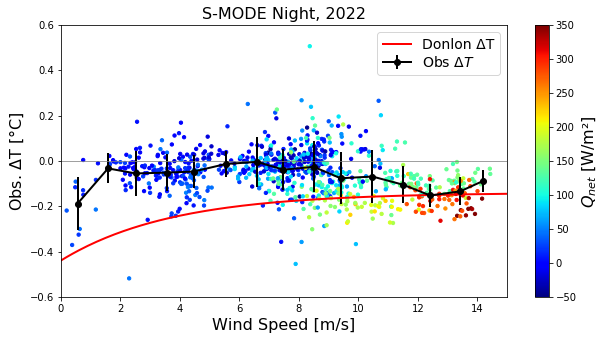

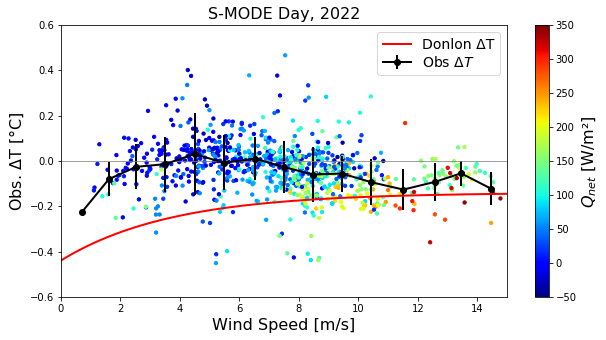

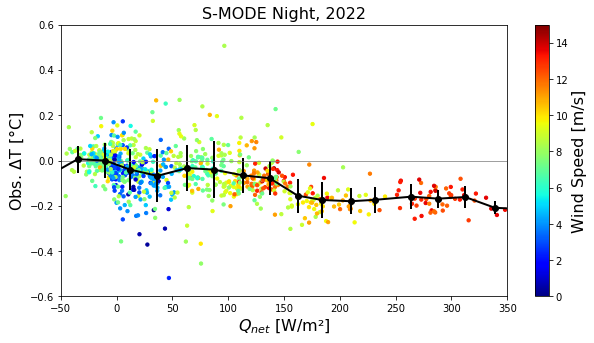

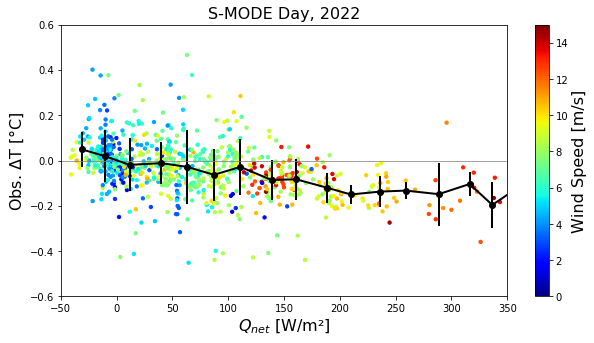

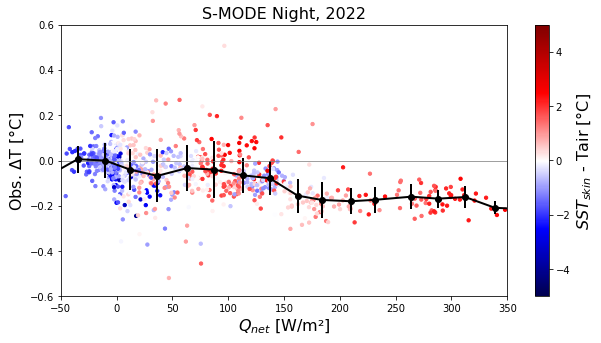

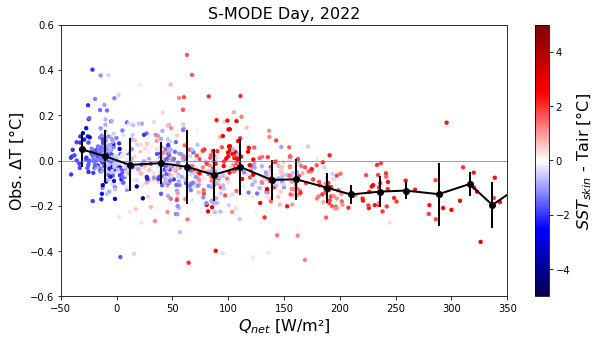

In [24]:
## DT dependences for day and night


xn=np.squeeze(np.array(dt_obs_ngt))
yn=np.squeeze(np.array(dt_mod_ngt))
zn=np.squeeze(np.array(dt_u10_ngt))
idx = pd.notnull(xn)
xn = xn[idx]
yn = yn[idx]
zn = zn[idx]

xyndif = xn - yn
mun = np.mean(xyndif)
sigman = np.std(xyndif)
varn = np.var(xyndif)
rmsn = rms(xyndif)
xn_ts = pd.Series(xn)
yn_ts = pd.Series(yn)
rn = xn_ts.corr(yn_ts)

print('Night mean, std dif, var, rms, rho: ', mun, sigman, varn, rmsn, rn)

textstr_n = '\n'.join((
     r'$rms=%.2f$' % (rmsn, ) +' $\u00B0$C',
     r'$\rho=%.2f$' % (rn, )))



xd=np.squeeze(np.array(dt_obs_day))
yd=np.squeeze(np.array(dt_mod_day))
zd=np.squeeze(np.array(dt_u10_day))
idxd = pd.notnull(xd)
xd = xd[idxd]
yd = yd[idxd]
zd = zd[idxd]
xyddif = xd - yd
mud = np.mean(xyddif)
sigmad = np.std(xyddif)
vard = np.var(xyddif)
rmsd = rms(xyddif)
xd_ts = pd.Series(xd)
yd_ts = pd.Series(yd)
rd = xd_ts.corr(yd_ts)
print('Day mean, std dif, var, rms, rho: ', mud, sigmad, vard, rmsd, rd)

textstr_d = '\n'.join((
     r'$rms=%.2f$' % (rmsd, ) +' $\u00B0$C',
     r'$\rho=%.2f$' % (rd, )))
    

bin_ctr_w_dto_n, _, _ = stats.binned_statistic(zn, zn, statistic='mean', bins=bins_u)
bin_avg_w_dto_n, _, _ = stats.binned_statistic(zn, xn, statistic='mean', bins=bins_u)
bin_std_w_dto_n, _, _ = stats.binned_statistic(zn, xn, statistic='std', bins=bins_u)
    
bin_ctr_w_dto_d, _, _ = stats.binned_statistic(zd, zd, statistic='mean', bins=bins_u)
bin_avg_w_dto_d, _, _ = stats.binned_statistic(zd, xd, statistic='mean', bins=bins_u)
bin_std_w_dto_d, _, _ = stats.binned_statistic(zd, xd, statistic='std', bins=bins_u)

qn=np.squeeze(np.array(dt_qnet_ngt))
qn = qn[idx]
bin_ctr_q_dto_n, _, _ = stats.binned_statistic(qn, qn, statistic='mean', bins=bins_q)
bin_avg_q_dto_n, _, _ = stats.binned_statistic(qn, xn, statistic='mean', bins=bins_q)
bin_std_q_dto_n, _, _ = stats.binned_statistic(qn, xn, statistic='std', bins=bins_q)

qd=np.squeeze(np.array(dt_qnet_day))
qd = qd[idxd]
bin_ctr_q_dto_d, _, _ = stats.binned_statistic(qd, qd, statistic='mean', bins=bins_q)
bin_avg_q_dto_d, _, _ = stats.binned_statistic(qd, xd, statistic='mean', bins=bins_q)
bin_std_q_dto_d, _, _ = stats.binned_statistic(qd, xd, statistic='std', bins=bins_q)

        
fig = plt.figure(figsize = (10,5))
fig = plt.scatter(dt_u10_ngt, dt_obs_ngt, c=dt_qnet_ngt, cmap='jet', marker='o', s=11)
plt.plot(bins_u,uzeroarr, color='grey',linewidth=1, alpha=0.75)
plt.errorbar(bin_ctr_w_dto_n, bin_avg_w_dto_n, bin_std_w_dto_n,fmt="o-", color="k",linewidth=2,label="Obs $ΔT$")
plt.plot(wndarr,donlon, color='r',linewidth=2,label="Donlon ΔT")
plt.xlabel('Wind Speed [m/s]', fontsize = 16)
plt.ylabel('Obs. ΔT [$\u00B0$C]',fontsize=16)
plt.title('S-MODE Night, 2022',fontsize=16)
plt.margins(x=0)  
plt.legend(loc='upper right',fontsize=14,labelspacing=0.2)
plt.xlim([0,15])
plt.ylim([-0.6,0.6])
plt.clim(-50,350)
cb = plt.colorbar()
cb.set_label('$Q_{net}$ [W/m\u00b2]',fontsize=16)
fig_fname = fig_dir_dtpaper + 'SMODE_dtobs_wspd_cQs_n.png'
#plt.savefig(fig_fname, dpi=300, transparent=False, format='png', bbox_inches='tight')
plt.draw()
plt.show()
    
fig = plt.figure(figsize = (10,5))
fig = plt.scatter(dt_u10_day, dt_obs_day, c=dt_qnet_day, cmap='jet', marker='o', s=11)
plt.plot(bins_u,uzeroarr, color='grey',linewidth=1, alpha=0.75)
plt.errorbar(bin_ctr_w_dto_d, bin_avg_w_dto_d, bin_std_w_dto_d,fmt="o-", color="k",linewidth=2,label="Obs $ΔT$")
plt.plot(wndarr,donlon, color='r',linewidth=2,label="Donlon ΔT")
plt.xlabel('Wind Speed [m/s]', fontsize = 16)
plt.ylabel('Obs. ΔT [$\u00B0$C]',fontsize=16)
plt.title('S-MODE Day, 2022',fontsize=16)
plt.margins(x=0)  
plt.legend(loc='upper right',fontsize=14,labelspacing=0.2)
plt.xlim([0,15])
plt.ylim([-0.6,0.6])
plt.clim(-50,350)
cb = plt.colorbar()
cb.set_label('$Q_{net}$ [W/m\u00b2]',fontsize=16)
fig_fname = fig_dir_dtpaper + 'SMODE_dtobs_wspd_cQs_d.png'
#plt.savefig(fig_fname, dpi=300, transparent=False, format='png', bbox_inches='tight')
plt.draw()
plt.show()
        
    
fig = plt.figure(figsize = (10,5))
fig = plt.scatter(dt_qnet_ngt, dt_obs_ngt, c=dt_u10_ngt, cmap='jet', marker='o', s=11)
plt.plot(bins_q,qzeroarr, color='grey', linewidth=1, alpha=0.75)
plt.errorbar(bin_ctr_q_dto_n, bin_avg_q_dto_n, bin_std_q_dto_n,fmt="o-", color="k",linewidth=2)
plt.xlabel('$Q_{net}$ [W/m\u00b2]', fontsize = 16)
plt.ylabel('Obs. ΔT [$\u00B0$C]',fontsize=16)
plt.title('S-MODE Night, 2022',fontsize=16)
plt.margins(x=0)  # no padding
plt.xlim([-50,350])
plt.ylim([-0.6,0.6])
plt.clim(0,15)
cb = plt.colorbar()
cb.set_label('Wind Speed [m/s]',fontsize=16)
fig_fname = fig_dir_dtpaper + 'SMODE_dtobs_qn_cU_n.png'
#plt.savefig(fig_fname, dpi=300, transparent=False, format='png', bbox_inches='tight')
plt.draw()
plt.show()
    
fig = plt.figure(figsize = (10,5))
fig = plt.scatter(dt_qnet_day, dt_obs_day, c=dt_u10_day, cmap='jet', marker='o', s=11)
plt.plot(bins_q,qzeroarr, color='grey', linewidth=1, alpha=0.75)
plt.errorbar(bin_ctr_q_dto_d, bin_avg_q_dto_d, bin_std_q_dto_d,fmt="o-", color="k",linewidth=2)
plt.xlabel('$Q_{net}$ [W/m\u00b2]', fontsize = 16)
plt.ylabel('Obs. ΔT [$\u00B0$C]',fontsize=16)
plt.title('S-MODE Day, 2022',fontsize=16)
plt.margins(x=0)  # no padding
plt.xlim([-50,350])
plt.ylim([-0.6,0.6])
plt.clim(0,15)
cb = plt.colorbar()
cb.set_label('Wind Speed [m/s]',fontsize=16)
fig_fname = fig_dir_dtpaper + 'SMODE_dtobs_qn_cU_d.png'
#plt.savefig(fig_fname, dpi=300, transparent=False, format='png', bbox_inches='tight')
plt.draw()
plt.show()
        
fig = plt.figure(figsize = (10,5))
fig = plt.scatter(dt_qnet_ngt, dt_obs_ngt, c=ts_ta_ngt, cmap='seismic', marker='o', s=11)
plt.plot(bins_q,qzeroarr, color='grey', linewidth=1, alpha=0.75)
plt.errorbar(bin_ctr_q_dto_n, bin_avg_q_dto_n, bin_std_q_dto_n,fmt="o-", color="k",linewidth=2)
plt.xlabel('$Q_{net}$ [W/m\u00b2]', fontsize = 16)
plt.ylabel('Obs. ΔT [$\u00B0$C]',fontsize=16)
plt.title('S-MODE Night, 2022',fontsize=16)
plt.margins(x=0)  
plt.xlim([-50,350])
plt.ylim([-0.6,0.6])
plt.clim([-5,5])
cb = plt.colorbar()
cb.set_label('$SST_{skin}$ - Tair [$\u00B0$C]',fontsize=16)
fig_fname = fig_dir_dtpaper + 'SMODE_dtobs_qn_cTsTa_n.png'
#plt.savefig(fig_fname, dpi=300, transparent=False, format='png', bbox_inches='tight')
plt.draw()
plt.show()
    
fig = plt.figure(figsize = (10,5))
fig = plt.scatter(dt_qnet_day, dt_obs_day, c=ts_ta_day, cmap='seismic', marker='o', s=11)
plt.plot(bins_q,qzeroarr, color='grey', linewidth=1, alpha=0.75)
plt.errorbar(bin_ctr_q_dto_d, bin_avg_q_dto_d, bin_std_q_dto_d,fmt="o-", color="k",linewidth=2)
plt.xlabel('$Q_{net}$ [W/m\u00b2]', fontsize = 16)
plt.ylabel('Obs. ΔT [$\u00B0$C]',fontsize=16)
plt.title('S-MODE Day, 2022',fontsize=16)
plt.margins(x=0)  
plt.xlim([-50,350])
plt.ylim([-0.6,0.6])
plt.clim([-5,5])
cb = plt.colorbar()
cb.set_label('$SST_{skin}$ - Tair [$\u00B0$C]',fontsize=16)
fig_fname = fig_dir_dtpaper + 'SMODE_dtobs_qn_cTsTa_d.png'
#plt.savefig(fig_fname, dpi=300, transparent=False, format='png', bbox_inches='tight')
plt.draw()
plt.show()
            

Night mean, std dif, var, rms, rho:  0.276805953579904 3.039794144750066 9.240348442456785 3.0523712058650507 0.9993908964887975
Day mean, std dif, var, rms, rho:  0.9499681246469379 3.532193923376387 12.476393912337073 3.6577087568835096 0.9990183126755304
Day and Ngt  mean, std dif, var, rms, rho:  0.6164048013865847 3.3145370680331574 10.98615597536584 3.3713663186515763 0.9992042011329455


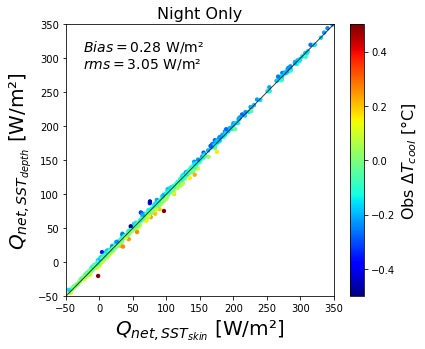

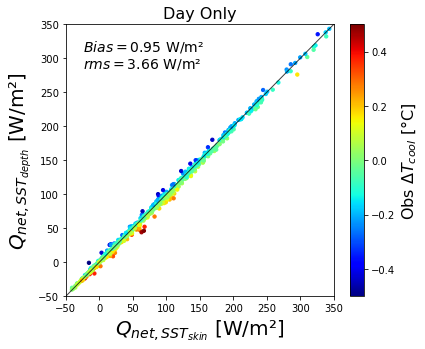

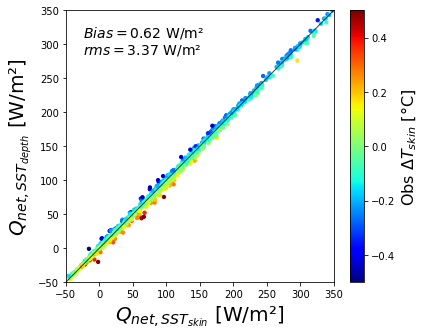

In [25]:
# paper  Fig. 9b

rms = lambda x_seq: (sum(x*x for x in x_seq)/len(x_seq))**(1/2)

day = (df_dt.flag_dn == 1)
ngt = (df_dt.flag_dn == 0)

qnet_s_ngt = df_dt.Qnplw[ngt]
qnet_s_day = df_dt.Qnplw[day]

qnet_d_ngt = df_dt.Qn_dtc[ngt]
qnet_d_day = df_dt.Qn_dtc[day]

## Qsnake - Qskin
err_qn_ngt = qnet_d_ngt - qnet_s_ngt
err_qn_day = qnet_d_day - qnet_s_day

dt_obs_ngt = dto[ngt]
dt_obs_day = dto[day]

xn=np.squeeze(np.array(qnet_s_ngt))
yn=np.squeeze(np.array(qnet_d_ngt))
idx = pd.notnull(xn)
xn = xn[idx]
yn = yn[idx]

xyndif = xn - yn
mun = np.mean(xyndif)
sigman = np.std(xyndif)
varn = np.var(xyndif)
rmsn = rms(xyndif)
xn_ts = pd.Series(xn)
yn_ts = pd.Series(yn)
rn = xn_ts.corr(yn_ts)

print('Night mean, std dif, var, rms, rho: ', mun, sigman, varn, rmsn, rn)

textstr_n = '\n'.join((
     r'$Bias=%.2f$' % (mun, ) +' W/m\u00b2',
     r'$rms=%.2f$' % (rmsn, ) +' W/m\u00b2'))


xd=np.squeeze(np.array(qnet_s_day))
yd=np.squeeze(np.array(qnet_d_day))
idx = pd.notnull(xd)
xd = xd[idx]
yd = yd[idx]
xyddif = xd - yd
mud = np.mean(xyddif)
sigmad = np.std(xyddif)
vard = np.var(xyddif)
rmsd = rms(xyddif)
xd_ts = pd.Series(xd)
yd_ts = pd.Series(yd)
rd = xd_ts.corr(yd_ts)
print('Day mean, std dif, var, rms, rho: ', mud, sigmad, vard, rmsd, rd)

textstr_d = '\n'.join((
     r'$Bias=%.2f$' % (mud, ) +' W/m\u00b2',
     r'$rms=%.2f$' % (rmsd, ) +' W/m\u00b2'))

xdn=np.squeeze(np.array(df_dt.Qnplw))
ydn=np.squeeze(np.array(df_dt.Qn_dtc))
idx = pd.notnull(xdn)
xdn = xdn[idx]
ydn = ydn[idx]
xydndif = xdn - ydn
mudn = np.mean(xydndif)
sigmadn = np.std(xydndif)
vardn = np.var(xydndif)
rmsdn = rms(xydndif)
xdn_ts = pd.Series(xdn)
ydn_ts = pd.Series(ydn)
rdn = xdn_ts.corr(ydn_ts)
print('Day and Ngt  mean, std dif, var, rms, rho: ', mudn, sigmadn, vardn, rmsdn, rdn)

textstr_dn = '\n'.join((
     r'$Bias=%.2f$' % (mudn, ) +' W/m\u00b2',
     r'$rms=%.2f$' % (rmsdn, ) +' W/m\u00b2'))


fig = plt.figure(figsize = (6,5))
plt.text(-25, 330, textstr_n, fontsize=14,verticalalignment='top')
fig = plt.scatter(qnet_s_ngt,qnet_d_ngt, c=dt_obs_ngt, cmap='jet', marker='o', s=11)
plt.plot(bins_q,bins_q, color='k', linewidth=1, alpha=0.75)
plt.ylabel('$Q_{net,SST_{depth}}$ [W/m\u00b2]', fontsize = 20)
plt.xlabel("$Q_{net,SST_{skin}}$ [W/m\u00b2]",fontsize=20)
#plt.title('S-MODE 2022, Night',fontsize=16)
plt.title('Night Only',fontsize=16)
plt.margins(x=0)  
plt.clim(-0.5,0.5)
plt.xlim([-50,350])
plt.ylim([-50,350])
cb = plt.colorbar()
cb.set_label('Obs $ΔT_{cool}$ [$\u00B0$C]',fontsize=16)
fig_fname = '/Users/sandrac/Documents/projects/AndyJ/DT_paper/plots_paper/SMODE_qnets_qnetcdtc_cdt_n_rev.png'
#plt.savefig(fig_fname, dpi=300, transparent=False, format='png', bbox_inches='tight')
plt.draw()
plt.show()

fig = plt.figure(figsize = (6,5))
plt.text(-25, 330, textstr_d, fontsize=14,verticalalignment='top')
fig = plt.scatter(qnet_s_day,qnet_d_day, c=dt_obs_day, cmap='jet', marker='o', s=11)
plt.plot(bins_q,bins_q, color='k', linewidth=1, alpha=0.75)
plt.ylabel('$Q_{net,SST_{depth}}$ [W/m\u00b2]', fontsize = 20)
plt.xlabel("$Q_{net,SST_{skin}}$ [W/m\u00b2]",fontsize=20)
#plt.title('S-MODE 2022, Day',fontsize=16)
plt.title('Day Only',fontsize=16)
plt.margins(x=0)  
plt.xlim([-50,350])
plt.ylim([-50,350])
plt.clim(-0.5,0.5)
cb = plt.colorbar()
cb.set_label('Obs $ΔT_{cool}$ [$\u00B0$C]',fontsize=16)
fig_fname = '/Users/sandrac/Documents/projects/AndyJ/DT_paper/plots_paper/SMODE_qnets_qnetcdtc_cdt_d_rev.png'
#plt.savefig(fig_fname, dpi=300, transparent=False, format='png', bbox_inches='tight')
plt.draw()
plt.show()

fig = plt.figure(figsize = (6,5))
plt.text(-25, 330, textstr_dn, fontsize=14,verticalalignment='top')
fig = plt.scatter(df_dt.Qnplw,df_dt.Qn_dtc, c=dto, cmap='jet', marker='o', s=11)
plt.plot(bins_q,bins_q, color='k', linewidth=1, alpha=0.75)
plt.ylabel('$Q_{net,SST_{depth}}$ [W/m\u00b2]', fontsize = 20)
plt.xlabel("$Q_{net,SST_{skin}}$ [W/m\u00b2]",fontsize= 20)
plt.margins(x=0)  # no padding
plt.xlim([-50,350])
plt.ylim([-50,350])
plt.clim(-0.5,0.5)
cb = plt.colorbar()
cb.set_label('Obs $ΔT_{skin}$ [$\u00B0$C]',fontsize=16)
fig_fname = '/Users/sandrac/Documents/projects/AndyJ/DT_paper/plots_paper/SMODE_qnets_qnetcdtc_cdt_dn_rev.png'#
#plt.savefig(fig_fname, dpi=300, transparent=False, format='png', bbox_inches='tight')
plt.draw()
plt.show()


Night mean, std dif, var, rms, rho:  0.0034249710203968567 0.08896517335696981 0.00791480207043569 0.08903107601801884 0.997781269359082
Day mean, std dif, var, rms, rho:  0.021248239185313468 0.11673459326123219 0.013626965263865315 0.11865265665943422 0.9961714166121912
Day and Ngt  mean, std dif, var, rms, rho:  0.012416506185483303 0.10428759241222414 0.010875901931138191 0.10502414749471828 0.996951364979131


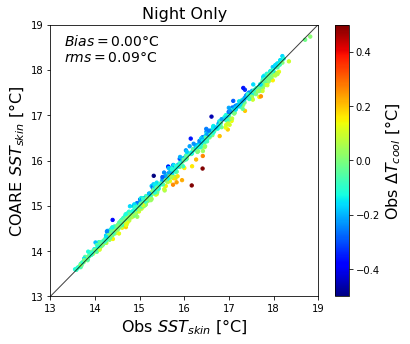

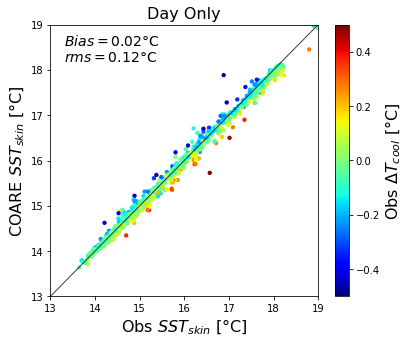

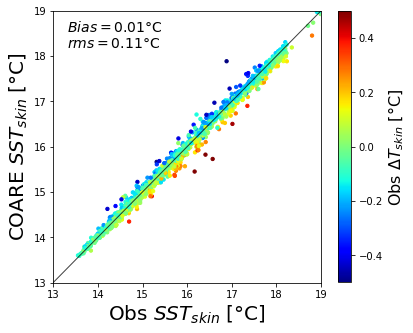

In [26]:
# paper Fig. 9a

bins_ts = np.arange(13,20,0.5)   
tszeroarr = np.zeros(len(bins_ts))

xn=np.squeeze(np.array(tskin_obs_ngt))
yn=np.squeeze(np.array(tskin_mod_ngt))
idx = pd.notnull(xn)
xn = xn[idx]
yn = yn[idx]

xyndif = xn - yn
mun = np.mean(xyndif)
sigman = np.std(xyndif)
varn = np.var(xyndif)
rmsn = rms(xyndif)
xn_ts = pd.Series(xn)
yn_ts = pd.Series(yn)
rn = xn_ts.corr(yn_ts)

print('Night mean, std dif, var, rms, rho: ', mun, sigman, varn, rmsn, rn)

textstr_n = '\n'.join((
     r'$Bias=%.2f$' % (mun, ) +'$\u00B0$C',
     r'$rms=%.2f$' % (rmsn, ) +'$\u00B0$C'))

xd=np.squeeze(np.array(tskin_obs_day))
yd=np.squeeze(np.array(tskin_mod_day))
idx = pd.notnull(xd)
xd = xd[idx]
yd = yd[idx]
xyddif = xd - yd
mud = np.mean(xyddif)
sigmad = np.std(xyddif)
vard = np.var(xyddif)
rmsd = rms(xyddif)
xd_ts = pd.Series(xd)
yd_ts = pd.Series(yd)
rd = xd_ts.corr(yd_ts)
print('Day mean, std dif, var, rms, rho: ', mud, sigmad, vard, rmsd, rd)

textstr_d = '\n'.join((
     r'$Bias=%.2f$' % (mud, ) +'$\u00B0$C',
     r'$rms=%.2f$' % (rmsd, ) +'$\u00B0$C'))

xdn=np.squeeze(np.array(tskin))
ydn=np.squeeze(np.array(tskin_coare))
idx = pd.notnull(xdn)
xdn = xdn[idx]
ydn = ydn[idx]
xydndif = xdn - ydn
mudn = np.mean(xydndif)
sigmadn = np.std(xydndif)
vardn = np.var(xydndif)
rmsdn = rms(xydndif)
xdn_ts = pd.Series(xdn)
ydn_ts = pd.Series(ydn)
rdn = xdn_ts.corr(ydn_ts)
print('Day and Ngt  mean, std dif, var, rms, rho: ', mudn, sigmadn, vardn, rmsdn, rdn)

textstr_dn = '\n'.join((
     r'$Bias=%.2f$' % (mudn, ) +'$\u00B0$C',
     r'$rms=%.2f$' % (rmsdn, ) +'$\u00B0$C'))

fig = plt.figure(figsize = (6,5))
plt.text(13.3, 18.8, textstr_n, fontsize=14,verticalalignment='top')
fig = plt.scatter(tskin_obs_ngt,tskin_mod_ngt, c=dt_obs_ngt, cmap='jet', marker='o', s=11)
plt.plot(bins_ts,bins_ts, color='k', linewidth=1, alpha=0.75)
plt.ylabel('COARE $SST_{skin}$ [$\u00B0$C]', fontsize = 16)
plt.xlabel("Obs $SST_{skin}$ [$\u00B0$C]",fontsize=16)
#plt.title('S-MODE 2022, Night',fontsize=16)
plt.title('Night Only',fontsize=16)
plt.margins(x=0)  
plt.clim(-0.5,0.5)
plt.xlim([13,19])
plt.ylim([13,19])
cb = plt.colorbar()
cb.set_label('Obs $ΔT_{cool}$ [$\u00B0$C]',fontsize=16)
fig_fname = '/Users/sandrac/Documents/projects/AndyJ/DT_paper/plots_paper/SMODE_obsts_modts_cdto_n.png'
#plt.savefig(fig_fname, dpi=300, transparent=False, format='png', bbox_inches='tight')
plt.draw()
plt.show()

fig = plt.figure(figsize = (6,5))
plt.text(13.3, 18.8, textstr_d, fontsize=14,verticalalignment='top')
fig = plt.scatter(tskin_obs_day,tskin_mod_day, c=dt_obs_day, cmap='jet', marker='o', s=11)
plt.plot(bins_ts,bins_ts, color='k', linewidth=1, alpha=0.75)
plt.ylabel('COARE $SST_{skin}$ [$\u00B0$C]', fontsize = 16)
plt.xlabel("Obs $SST_{skin}$ [$\u00B0$C]",fontsize=16)
#plt.title('S-MODE 2022, Day',fontsize=16)
plt.title('Day Only',fontsize=16)
plt.margins(x=0)  
plt.xlim([13,19])
plt.ylim([13,19])
plt.clim(-0.5,0.5)
cb = plt.colorbar()
cb.set_label('Obs $ΔT_{cool}$ [$\u00B0$C]',fontsize=16)
fig_fname = '/Users/sandrac/Documents/projects/AndyJ/DT_paper/plots_paper/SMODE_obsts_modts_cdto_d.png'
#plt.savefig(fig_fname, dpi=300, transparent=False, format='png', bbox_inches='tight')
plt.draw()
plt.show()


fig = plt.figure(figsize = (6,5))
plt.text(13.3, 18.8, textstr_dn, fontsize=14,verticalalignment='top')
fig = plt.scatter(tskin,tskin_coare, c=dto, cmap='jet', marker='o', s=11)
plt.plot(bins_ts,bins_ts, color='k', linewidth=1, alpha=0.75)
plt.ylabel('COARE $SST_{skin}$ [$\u00B0$C]', fontsize = 20)
plt.xlabel("Obs $SST_{skin}$ [$\u00B0$C]",fontsize=20)
#plt.title('S-MODE 2022, Day and Night',fontsize=16)
#plt.title('Day and Night',fontsize=16)
plt.margins(x=0)  
plt.xlim([13,19])
plt.ylim([13,19])
plt.clim(-0.5,0.5)
cb = plt.colorbar()
cb.set_label('Obs $ΔT_{skin}$ [$\u00B0$C]',fontsize=16)
fig_fname = '/Users/sandrac/Documents/projects/AndyJ/DT_paper/plots_paper/SMODE_obsts_modts_cdto_dn_rev.png'
#plt.savefig(fig_fname, dpi=300, transparent=False, format='png', bbox_inches='tight')
plt.draw()
plt.show()


Night mean, std dif, var, rms, rho:  0.0034249710203968138 0.08896517335696982 0.007914802070435694 0.08903107601801888 0.5289704767644454
Day mean, std dif, var, rms, rho:  0.02124823918531349 0.11673459326123219 0.013626965263865315 0.1186526566594343 0.42232817072566936
Day and Ngt  mean, std dif, var, rms, rho:  0.01241650618548329 0.10428759241222416 0.010875901931138193 0.10502414749471833 0.4631374702552983


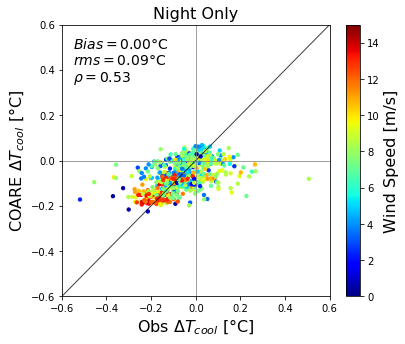

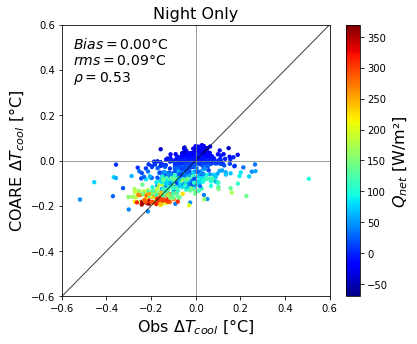

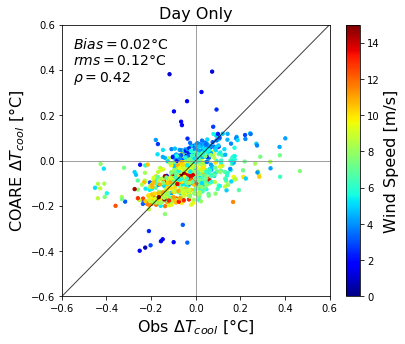

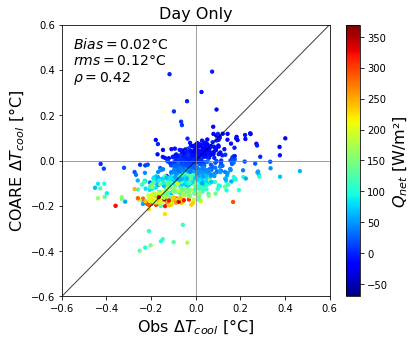

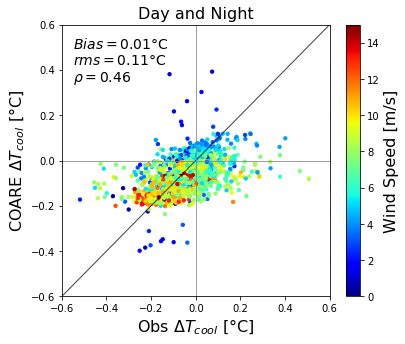

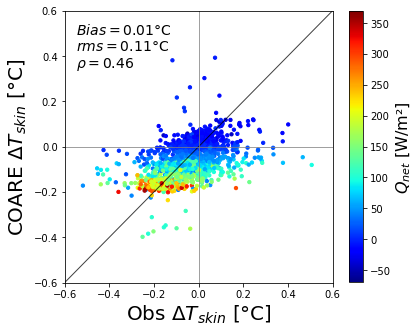

Day and Ngt  mean w U>6, std dif, var, rms, rho:  0.015567265662419824 0.09459962659446469 0.008949089351812151 0.09587194121335246 0.4756649051852769


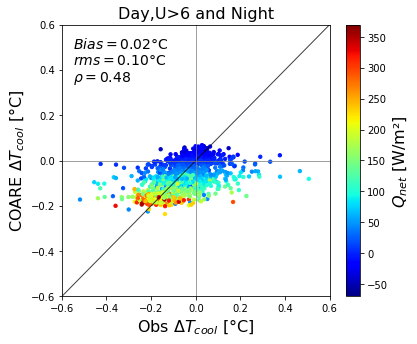

In [27]:
## Paper Fig. 11

bins_dt = np.arange(-0.65,0.65,0.05)   
dtzeroarr = np.zeros(len(bins_dt))

wnd6 = (df_dt.flag_dn == 0) | (df_dt.flag_dn == 1) & (df_dt.true_wspd >= 6)

wnd = df_dt.true_wspd
wnd_ngt = wnd[ngt]
wnd_day = wnd[day]

qnet_s_ngt = df_dt.Qnplw[ngt]
qnet_s_day = df_dt.Qnplw[day]

xn=np.squeeze(np.array(dt_obs_ngt))
yn=np.squeeze(np.array(dt_mod_ngt))
idx = pd.notnull(xn)
xn = xn[idx]
yn = yn[idx]

xyndif = xn - yn
mun = np.mean(xyndif)
sigman = np.std(xyndif)
varn = np.var(xyndif)
rmsn = rms(xyndif)
xn_ts = pd.Series(xn)
yn_ts = pd.Series(yn)
rn = xn_ts.corr(yn_ts)

print('Night mean, std dif, var, rms, rho: ', mun, sigman, varn, rmsn, rn)

textstr_n = '\n'.join((
     r'$Bias=%.2f$' % (mun, ) +'$\u00B0$C',
     r'$rms=%.2f$' % (rmsn, ) +'$\u00B0$C',
     r'$\rho=%.2f$' % (rn, )))

xd=np.squeeze(np.array(dt_obs_day))
yd=np.squeeze(np.array(dt_mod_day))
idx = pd.notnull(xd)
xd = xd[idx]
yd = yd[idx]
xyddif = xd - yd
mud = np.mean(xyddif)
sigmad = np.std(xyddif)
vard = np.var(xyddif)
rmsd = rms(xyddif)
xd_ts = pd.Series(xd)
yd_ts = pd.Series(yd)
rd = xd_ts.corr(yd_ts)
print('Day mean, std dif, var, rms, rho: ', mud, sigmad, vard, rmsd, rd)


textstr_d = '\n'.join((
     r'$Bias=%.2f$' % (mud, ) +'$\u00B0$C',
     r'$rms=%.2f$' % (rmsd, ) +'$\u00B0$C',
     r'$\rho=%.2f$' % (rd, )))

xdn=np.squeeze(np.array(dto))
ydn=np.squeeze(np.array(dtm))
idx = pd.notnull(xdn)
xdn = xdn[idx]
ydn = ydn[idx]
xydndif = xdn - ydn
mudn = np.mean(xydndif)
sigmadn = np.std(xydndif)
vardn = np.var(xydndif)
rmsdn = rms(xydndif)
xdn_ts = pd.Series(xdn)
ydn_ts = pd.Series(ydn)
rdn = xdn_ts.corr(ydn_ts)
print('Day and Ngt  mean, std dif, var, rms, rho: ', mudn, sigmadn, vardn, rmsdn, rdn)

textstr_dn = '\n'.join((
     r'$Bias=%.2f$' % (mudn, ) +'$\u00B0$C',
     r'$rms=%.2f$' % (rmsdn, ) +'$\u00B0$C',
     r'$\rho=%.2f$' % (rdn, )))

fig = plt.figure(figsize = (6,5))
plt.text(-0.55, 0.55, textstr_n, fontsize=14,verticalalignment='top')
fig = plt.scatter(dt_obs_ngt,dt_mod_ngt, c=wnd_ngt, cmap='jet', marker='o', s=11)
plt.plot(bins_dt,bins_dt, color='k', linewidth=1, alpha=0.75)
plt.plot([-0.65,0.65],[0.0,0.0],color='grey',linewidth=1, alpha=0.75)
plt.plot([0.0,0.0],[-0.65,0.65],color='grey',linewidth=1, alpha=0.75)
plt.xlabel('Obs $ΔT_{cool}$ [$\u00B0$C]', fontsize = 16)
plt.ylabel("COARE $ΔT_{cool}$ [$\u00B0$C]",fontsize=16)
#plt.title('S-MODE 2022, Night',fontsize=16)
plt.title('Night Only',fontsize=16)
plt.margins(x=0)  
plt.clim(0,15)
plt.xlim([-0.6,0.6])
plt.ylim([-0.6,0.6])
cb = plt.colorbar()
cb.set_label('Wind Speed [m/s]',fontsize=16)
fig_fname = '/Users/sandrac/Documents/projects/AndyJ/DT_paper/plots_paper/SMODE_dto_dtm_cU_n.png'
#plt.savefig(fig_fname, dpi=300, transparent=False, format='png', bbox_inches='tight')
plt.draw()
plt.show()


fig = plt.figure(figsize = (6,5))
plt.text(-0.55, 0.55, textstr_n, fontsize=14,verticalalignment='top')
fig = plt.scatter(dt_obs_ngt,dt_mod_ngt, c=qnet_s_ngt, cmap='jet', marker='o', s=11)
plt.plot(bins_dt,bins_dt, color='k', linewidth=1, alpha=0.75)
plt.plot([-0.65,0.65],[0.0,0.0],color='grey',linewidth=1, alpha=0.75)
plt.plot([0.0,0.0],[-0.65,0.65],color='grey',linewidth=1, alpha=0.75)
plt.xlabel('Obs $ΔT_{cool}$ [$\u00B0$C]', fontsize = 16)
plt.ylabel("COARE $ΔT_{cool}$ [$\u00B0$C]",fontsize=16)
#plt.title('S-MODE 2022, Night',fontsize=16)
plt.title('Night Only',fontsize=16)
plt.margins(x=0)  
plt.clim([-70,370])
plt.xlim([-0.6,0.6])
plt.ylim([-0.6,0.6])
cb = plt.colorbar()
cb.set_label('$Q_{net}$ [W/m\u00b2]',fontsize=16)
fig_fname = '/Users/sandrac/Documents/projects/AndyJ/DT_paper/plots_paper/SMODE_dto_dtm_cQn_n.png'
#plt.savefig(fig_fname, dpi=300, transparent=False, format='png', bbox_inches='tight')
plt.draw()
plt.show()


fig = plt.figure(figsize = (6,5))
plt.text(-0.55, 0.55, textstr_d, fontsize=14,verticalalignment='top')
fig = plt.scatter(dt_obs_day,dt_mod_day, c=wnd_day, cmap='jet', marker='o', s=11)
plt.plot(bins_dt,bins_dt, color='k', linewidth=1, alpha=0.75)
plt.plot([-0.65,0.65],[0.0,0.0],color='grey',linewidth=1, alpha=0.75)
plt.plot([0.0,0.0],[-0.65,0.65],color='grey',linewidth=1, alpha=0.75)
plt.xlabel('Obs $ΔT_{cool}$ [$\u00B0$C]', fontsize = 16)
plt.ylabel("COARE $ΔT_{cool}$ [$\u00B0$C]",fontsize=16)
#plt.title('S-MODE 2022, Day',fontsize=16)
plt.title('Day Only',fontsize=16)
plt.margins(x=0)  # no padding
plt.xlim([-0.6,0.6])
plt.ylim([-0.6,0.6])
plt.clim(0,15)
cb = plt.colorbar()
cb.set_label('Wind Speed [m/s]',fontsize=16)
fig_fname = '/Users/sandrac/Documents/projects/AndyJ/DT_paper/plots_paper/SMODE_dto_dtm_cU_d.png'
#plt.savefig(fig_fname, dpi=300, transparent=False, format='png', bbox_inches='tight')
plt.draw()
plt.show()

fig = plt.figure(figsize = (6,5))
plt.text(-0.55, 0.55, textstr_d, fontsize=14,verticalalignment='top')
fig = plt.scatter(dt_obs_day,dt_mod_day, c=qnet_s_day, cmap='jet', marker='o', s=11)
plt.plot(bins_dt,bins_dt, color='k', linewidth=1, alpha=0.75)
plt.plot([-0.65,0.65],[0.0,0.0],color='grey',linewidth=1, alpha=0.75)
plt.plot([0.0,0.0],[-0.65,0.65],color='grey',linewidth=1, alpha=0.75)
plt.xlabel('Obs $ΔT_{cool}$ [$\u00B0$C]', fontsize = 16)
plt.ylabel("COARE $ΔT_{cool}$ [$\u00B0$C]",fontsize=16)
#plt.title('S-MODE 2022, Day',fontsize=16)
plt.title('Day Only',fontsize=16)
plt.margins(x=0)  # no padding
plt.xlim([-0.6,0.6])
plt.ylim([-0.6,0.6])
plt.clim([-70,370])
cb = plt.colorbar()
cb.set_label('$Q_{net}$ [W/m\u00b2]',fontsize=16)
fig_fname = '/Users/sandrac/Documents/projects/AndyJ/DT_paper/plots_paper/SMODE_dto_dtm_cQn_d.png'
#plt.savefig(fig_fname, dpi=300, transparent=False, format='png', bbox_inches='tight')
plt.draw()
plt.show()


fig = plt.figure(figsize = (6,5))
plt.text(-0.55, 0.55, textstr_dn, fontsize=14,verticalalignment='top')
fig = plt.scatter(dto,dtm, c=wnd, cmap='jet', marker='o', s=11)
plt.plot(bins_dt,bins_dt, color='k', linewidth=1, alpha=0.75)
plt.plot([-0.65,0.65],[0.0,0.0],color='grey',linewidth=1, alpha=0.75)
plt.plot([0.0,0.0],[-0.65,0.65],color='grey',linewidth=1, alpha=0.75)
plt.xlabel('Obs $ΔT_{cool}$ [$\u00B0$C]', fontsize = 16)
plt.ylabel("COARE $ΔT_{cool}$ [$\u00B0$C]",fontsize=16)
#plt.title('S-MODE 2022, Day and Night',fontsize=16)
plt.title('Day and Night',fontsize=16)
plt.margins(x=0)  # no padding
plt.xlim([-0.6,0.6])
plt.ylim([-0.6,0.6])
plt.clim(13,19)
plt.clim(0,15)
cb = plt.colorbar()
cb.set_label('Wind Speed [m/s]',fontsize=16)
fig_fname = '/Users/sandrac/Documents/projects/AndyJ/DT_paper/plots_paper/SMODE_dto_dtm_cU_dn.png'
#plt.savefig(fig_fname, dpi=300, transparent=False, format='png', bbox_inches='tight')
plt.draw()
plt.show()


fig = plt.figure(figsize = (6,5))
plt.text(-0.55, 0.55, textstr_dn, fontsize=14,verticalalignment='top')
fig = plt.scatter(dto,dtm, c=df_dt.Qnplw, cmap='jet', marker='o', s=11)
plt.plot(bins_dt,bins_dt, color='k', linewidth=1, alpha=0.75)
plt.plot([-0.65,0.65],[0.0,0.0],color='grey',linewidth=1, alpha=0.75)
plt.plot([0.0,0.0],[-0.65,0.65],color='grey',linewidth=1, alpha=0.75)
plt.xlabel('Obs $ΔT_{skin}$ [$\u00B0$C]', fontsize = 20)
plt.ylabel("COARE $ΔT_{skin}$ [$\u00B0$C]",fontsize=20)
#plt.title('S-MODE 2022, Day and Night',fontsize=16)
#plt.title('Day and Night',fontsize=16)
plt.margins(x=0)  # no padding
plt.xlim([-0.6,0.6])
plt.ylim([-0.6,0.6])
plt.clim([-70,370])
cb = plt.colorbar()
cb.set_label('$Q_{net}$ [W/m\u00b2]',fontsize=16)
fig_fname = '/Users/sandrac/Documents/projects/AndyJ/DT_paper/plots_paper/SMODE_dto_dtm_cQn_dn_rev.png'
#plt.savefig(fig_fname, dpi=300, transparent=False, format='png', bbox_inches='tight')
plt.draw()
plt.show()
 

wnd6 = (df_dt.flag_dn == 0) | (df_dt.flag_dn == 1) & (df_dt.true_wspd >= 6)
dto_6 = dto[wnd6]
dtm_6 = dtm[wnd6]
qn_6 = df_dt.Qnplw[wnd6]
xdn=np.squeeze(np.array(dto_6))
ydn=np.squeeze(np.array(dtm_6))
idx = pd.notnull(xdn)
xdn6 = xdn[idx]
ydn6 = ydn[idx]
xydndif6 = xdn6 - ydn6
mudn6 = np.mean(xydndif6)
sigmadn6 = np.std(xydndif6)
vardn6 = np.var(xydndif6)
rmsdn6 = rms(xydndif6)
xdn_ts6 = pd.Series(xdn6)
ydn_ts6 = pd.Series(ydn6)
rdn6 = xdn_ts6.corr(ydn_ts6)
print('Day and Ngt  mean w U>6, std dif, var, rms, rho: ', mudn6, sigmadn6, vardn6, rmsdn6, rdn6)

textstr_dn6 = '\n'.join((
     r'$Bias=%.2f$' % (mudn6, ) +'$\u00B0$C',
     r'$rms=%.2f$' % (rmsdn6, ) +'$\u00B0$C',
     r'$\rho=%.2f$' % (rdn6, )))

fig = plt.figure(figsize = (6,5))
plt.text(-0.55, 0.55, textstr_dn6, fontsize=14,verticalalignment='top')
fig = plt.scatter(dto_6,dtm_6, c=qn_6, cmap='jet', marker='o', s=11)
plt.plot(bins_dt,bins_dt, color='k', linewidth=1, alpha=0.75)
plt.plot([-0.65,0.65],[0.0,0.0],color='grey',linewidth=1, alpha=0.75)
plt.plot([0.0,0.0],[-0.65,0.65],color='grey',linewidth=1, alpha=0.75)
plt.xlabel('Obs $ΔT_{cool}$ [$\u00B0$C]', fontsize = 16)
plt.ylabel("COARE $ΔT_{cool}$ [$\u00B0$C]",fontsize=16)
#plt.title('S-MODE 2022, Day and Night',fontsize=16)
plt.title('Day,U>6 and Night',fontsize=16)
plt.margins(x=0)  # no padding
plt.xlim([-0.6,0.6])
plt.ylim([-0.6,0.6])
plt.clim([-70,370])
cb = plt.colorbar()
cb.set_label('$Q_{net}$ [W/m\u00b2]',fontsize=16)
fig_fname = '/Users/sandrac/Documents/projects/AndyJ/DT_paper/plots_paper/SMODE_dto6_dtm6_cQn_dn.png'
#plt.savefig(fig_fname, dpi=300, transparent=False, format='png', bbox_inches='tight')
plt.draw()
plt.show()


## Extra plots

Night mean, std dif, var, rms, rho:  0.0034249710203968138 0.08896517335696982 0.007914802070435694 0.08903107601801888 0.5289704767644454
Day mean, std dif, var, rms, rho:  0.02124823918531349 0.11673459326123219 0.013626965263865315 0.1186526566594343 0.42232817072566936
Day and Ngt  mean, std dif, var, rms, rho:  0.01241650618548329 0.10428759241222416 0.010875901931138193 0.10502414749471833 0.4631374702552983
Day and Ngt  mean, std dif, var, rms, rho:  0.01241650618548329 0.10428759241222416 0.010875901931138193 0.10502414749471833 0.4631374702552983


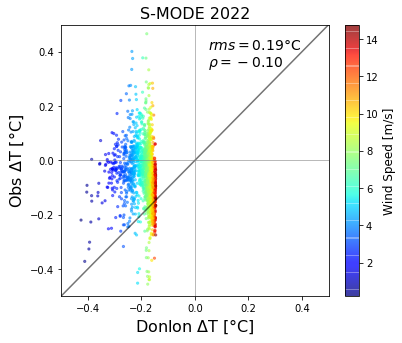

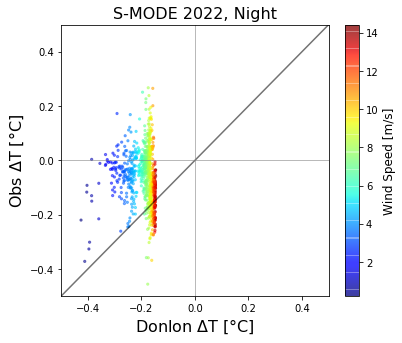

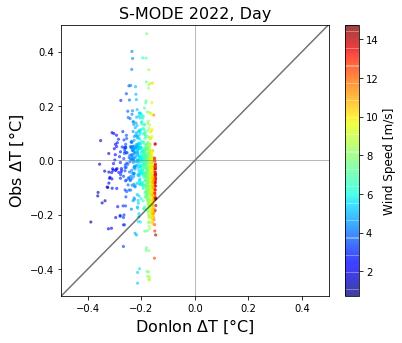

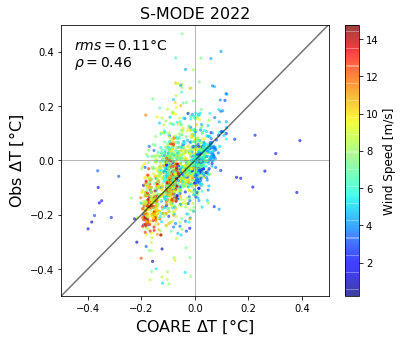

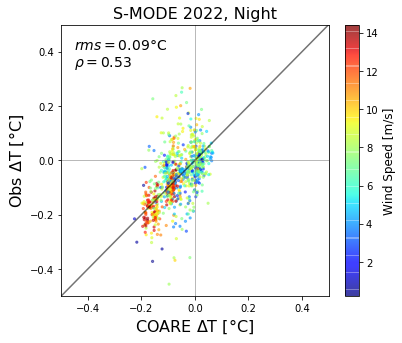

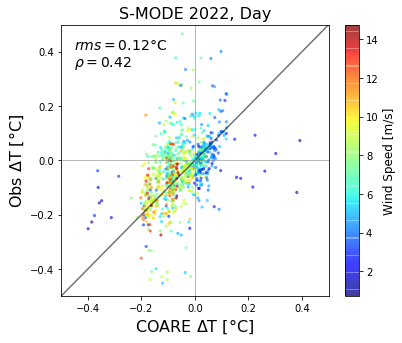

Night mean & U10 < 10:, std dif, var, rms, rho:  0.00498559321658678 0.09537295447875609 0.00909600044600688 0.08903107601801888 0.5289704767644454
Night mean and U10 > 10, std dif, var, rms, rho:  -0.002084110612055196 0.06087823652834275 0.0037061596828008455 0.06091389989028881 0.7452575963876347


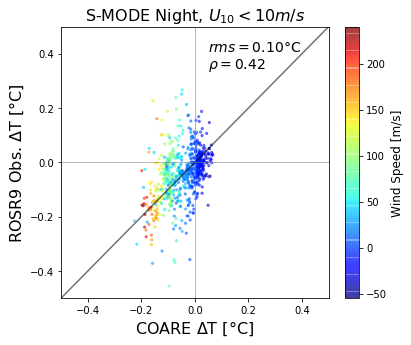

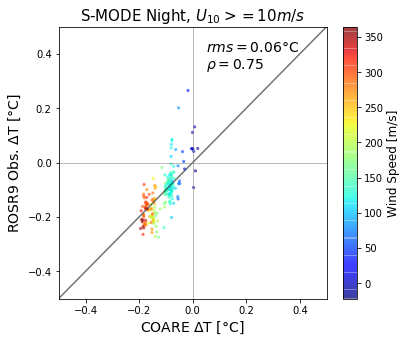

In [29]:
day = (df_dt.flag_dn == 1)
ngt = (df_dt.flag_dn == 0)

dt_obs_ngt = dto[ngt]
dt_obs_day = dto[day]

dt_mod_ngt = dtm[ngt]
dt_mod_day = dtm[day]

dt_qnet_ngt = df_dt.Qnplw[ngt]
dt_qnet_day = df_dt.Qnplw[day]

dtc_qnet_ngt = df_dt.Qn_dtc[ngt]
dtc_qnet_day = df_dt.Qn_dtc[day]

dt_u10_ngt = df_dt.true_wspd[ngt]
dt_u10_day = df_dt.true_wspd[day]

dt_donlon_ngt = donlon_smode[ngt]
dt_donlon_day = donlon_smode[day]

rms = lambda x_seq: (sum(x*x for x in x_seq)/len(x_seq))**(1/2)

xn=np.squeeze(np.array(dt_obs_ngt))
yn=np.squeeze(np.array(dt_mod_ngt))
zn=np.squeeze(np.array(dt_u10_ngt))
idx = pd.notnull(xn)
xn = xn[idx]
yn = yn[idx]
zn = zn[idx]

xyndif = xn - yn
mun = np.mean(xyndif)
sigman = np.std(xyndif)
varn = np.var(xyndif)
rmsn = rms(xyndif)
xn_ts = pd.Series(xn)
yn_ts = pd.Series(yn)
rn = xn_ts.corr(yn_ts)

print('Night mean, std dif, var, rms, rho: ', mun, sigman, varn, rmsn, rn)

textstr_n = '\n'.join((
     r'$rms=%.2f$' % (rmsn, ) +'$\u00B0$C',
     r'$\rho=%.2f$' % (rn, )))

xd=np.squeeze(np.array(dt_obs_day))
yd=np.squeeze(np.array(dt_mod_day))
idx = pd.notnull(xd)
xd = xd[idx]
yd = yd[idx]
xyddif = xd - yd
mud = np.mean(xyddif)
sigmad = np.std(xyddif)
vard = np.var(xyddif)
rmsd = rms(xyddif)
xd_ts = pd.Series(xd)
yd_ts = pd.Series(yd)
rd = xd_ts.corr(yd_ts)
print('Day mean, std dif, var, rms, rho: ', mud, sigmad, vard, rmsd, rd)

textstr_d = '\n'.join((
     r'$rms=%.2f$' % (rmsd, ) +'$\u00B0$C',
     r'$\rho=%.2f$' % (rd, )))
    
xdn=np.squeeze(np.array(dto))
ydn=np.squeeze(np.array(dtm))
idx = pd.notnull(xdn)
xdn = xdn[idx]
ydn = ydn[idx]
xydndif = xdn - ydn
mudn = np.mean(xydndif)
sigmadn = np.std(xydndif)
vardn = np.var(xydndif)
rmsdn = rms(xydndif)
xdn_ts = pd.Series(xdn)
ydn_ts = pd.Series(ydn)
rdn = xdn_ts.corr(ydn_ts)
print('Day and Ngt  mean, std dif, var, rms, rho: ', mudn, sigmadn, vardn, rmsdn, rdn)

textstr_dn = '\n'.join((
     r'$rms=%.2f$' % (rmsdn, ) +'$\u00B0$C',
     r'$\rho=%.2f$' % (rdn, )))

xddon=np.squeeze(np.array(dto))
yddon=np.squeeze(np.array(donlon_smode))
idx = pd.notnull(xdn)
xddon = xddon[idx]
yddon = yddon[idx]
xydondif = xddon - yddon
muddon = np.mean(xydondif)
sigmaddon = np.std(xydondif)
vardon = np.var(xydondif)
rmsdon = rms(xydondif)
xdon_ts = pd.Series(xddon)
ydon_ts = pd.Series(yddon)
rdon = xdon_ts.corr(ydon_ts)
print('Day and Ngt  mean, std dif, var, rms, rho: ', mudn, sigmadn, vardn, rmsdn, rdn)

textstr_don = '\n'.join((
     r'$rms=%.2f$' % (rmsdon, ) +'$\u00B0$C',
     r'$\rho=%.2f$' % (rdon, )))

fig, ax = plt.subplots(figsize=(6,5))
plt.text(0.55, 0.95, textstr_don, transform=ax.transAxes, fontsize=14,verticalalignment='top')
fig = ax.scatter(donlon_smode,dto, c=df_dt.true_wspd, cmap='jet', marker='o', s=5, alpha=0.5)
plt.plot([-0.5,0.5],[-0.5,0.5],color='k', alpha=0.55)
plt.plot([-0.5,0.5],[0.0,0.0],color='grey', linewidth=1,  alpha=0.55)
plt.plot([0.0,0.0],[-0.5,0.5],color='grey', linewidth=1, alpha=0.55)
plt.ylabel('Obs ΔT [$\u00B0$C]', fontsize = 16)
plt.xlabel("Donlon ΔT [$\u00B0$C]",fontsize=16)
plt.title('S-MODE 2022',fontsize=16)
plt.margins(x=0)  
plt.ylim([-0.5,0.5])
plt.xlim([-0.5,0.5])
cb = plt.colorbar(fig, ax=ax)
cb.set_label('Wind Speed [m/s]' ,fontsize=12)
#fig_fname = '/Users/sandrac/Documents/projects/AndyJ/presentations/SMODE_STM_SanJose_2024/poster/plots_smode_stm24/SMODE_dtobs_dtdonlon_cU_dn_stm24.png'
#plt.savefig(fig_fname, dpi=300, transparent=False, format='png', bbox_inches='tight')
plt.draw()
plt.show()

fig, ax = plt.subplots(figsize=(6,5))
fig = ax.scatter(dt_donlon_ngt,dt_obs_ngt, c=dt_u10_ngt, cmap='jet', marker='o', s=5, alpha=0.5)
plt.plot([-0.5,0.5],[-0.5,0.5],color='k', alpha=0.55)
plt.plot([-0.5,0.5],[0.0,0.0],color='grey', linewidth=1,  alpha=0.55)
plt.plot([0.0,0.0],[-0.5,0.5],color='grey', linewidth=1, alpha=0.55)
plt.ylabel('Obs ΔT [$\u00B0$C]', fontsize = 16)
plt.xlabel("Donlon ΔT [$\u00B0$C]",fontsize=16)
plt.title('S-MODE 2022, Night',fontsize=16)
plt.margins(x=0)  
plt.ylim([-0.5,0.5])
plt.xlim([-0.5,0.5])
cb = plt.colorbar(fig, ax=ax)
cb.set_label('Wind Speed [m/s]' ,fontsize=12)
#fig_fname = fig_dir+'ROSR9_dtmod_dtobs_n.png'
#plt.savefig(fig_fname, dpi=300, transparent=False, format='png', bbox_inches='tight')
plt.draw()
plt.show()

fig, ax = plt.subplots(figsize=(6,5))
fig = ax.scatter(dt_donlon_day,dt_obs_day, c=dt_u10_day, cmap='jet', marker='o', s=5, alpha=0.5)
plt.plot([-0.5,0.5],[-0.5,0.5],color='k', alpha=0.55)
plt.plot([-0.5,0.5],[0.0,0.0],color='grey', linewidth=1,  alpha=0.55)
plt.plot([0.0,0.0],[-0.5,0.5],color='grey', linewidth=1, alpha=0.55)
plt.ylabel('Obs ΔT [$\u00B0$C]', fontsize = 16)
plt.xlabel("Donlon ΔT [$\u00B0$C]",fontsize=16)
plt.title('S-MODE 2022, Day',fontsize=16)
plt.margins(x=0)  
plt.ylim([-0.5,0.5])
plt.xlim([-0.5,0.5])
cb = plt.colorbar(fig, ax=ax)
cb.set_label('Wind Speed [m/s]' ,fontsize=12)
#fig_fname = '/Users/sandrac/Documents/projects/AndyJ/presentations/SMODE_STM_SanJose_2024/poster/plots_smode_stm24/SMODE_dtdonlon_dtm_cU_d_stm24.png'
#plt.savefig(fig_fname, dpi=300, transparent=False, format='png', bbox_inches='tight')
plt.draw()
plt.show()

fig, ax = plt.subplots(figsize=(6,5))
plt.text(0.05, 0.95, textstr_dn, transform=ax.transAxes, fontsize=14,verticalalignment='top')
fig = ax.scatter(dtm,dto, c=df_dt.true_wspd, cmap='jet', marker='o', s=5, alpha=0.5)
plt.plot([-0.5,0.5],[-0.5,0.5],color='k', alpha=0.55)
plt.plot([-0.5,0.5],[0.0,0.0],color='grey', linewidth=1,  alpha=0.55)
plt.plot([0.0,0.0],[-0.5,0.5],color='grey', linewidth=1, alpha=0.55)
plt.ylabel('Obs ΔT [$\u00B0$C]', fontsize = 16)
plt.xlabel("COARE ΔT [$\u00B0$C]",fontsize=16)
plt.title('S-MODE 2022',fontsize=16)
plt.margins(x=0)  
plt.ylim([-0.5,0.5])
plt.xlim([-0.5,0.5])
cb = plt.colorbar(fig, ax=ax)
cb.set_label('Wind Speed [m/s]' ,fontsize=12)
#fig_fname = '/Users/sandrac/Documents/projects/AndyJ/presentations/SMODE_STM_SanJose_2024/poster/plots_smode_stm24/SMODE_dtobs_dtm_cU_dn_stm24.png'
#plt.savefig(fig_fname, dpi=300, transparent=False, format='png', bbox_inches='tight')
plt.draw()
plt.show()
 
    
fig, ax = plt.subplots(figsize=(6,5))
plt.text(0.05, 0.95, textstr_n, transform=ax.transAxes, fontsize=14,verticalalignment='top')
fig = ax.scatter(dt_mod_ngt,dt_obs_ngt, c=dt_u10_ngt, cmap='jet', marker='o', s=5, alpha=0.5)
plt.plot([-0.5,0.5],[-0.5,0.5],color='k', alpha=0.55)
plt.plot([-0.5,0.5],[0.0,0.0],color='grey', linewidth=1,  alpha=0.55)
plt.plot([0.0,0.0],[-0.5,0.5],color='grey', linewidth=1, alpha=0.55)
plt.ylabel('Obs ΔT [$\u00B0$C]', fontsize = 16)
plt.xlabel("COARE ΔT [$\u00B0$C]",fontsize=16)
plt.title('S-MODE 2022, Night',fontsize=16)
plt.margins(x=0)  
plt.ylim([-0.5,0.5])
plt.xlim([-0.5,0.5])
cb = plt.colorbar(fig, ax=ax)
#cb.set_label('$Q_{net}$ [W/m\u00b2]',fontsize=16)
cb.set_label('Wind Speed [m/s]' ,fontsize=12)
#fig_fname = fig_dir+'ROSR9_dtmod_dtobs_n.png'
#plt.savefig(fig_fname, dpi=300, transparent=False, format='png', bbox_inches='tight')
plt.draw()
plt.show()

fig, ax = plt.subplots(figsize=(6,5))
plt.text(0.05, 0.95, textstr_d, transform=ax.transAxes, fontsize=14,verticalalignment='top')
fig = ax.scatter(dt_mod_day,dt_obs_day, c=dt_u10_day, cmap='jet', marker='o', s=5, alpha=0.5)
plt.plot([-0.5,0.5],[-0.5,0.5],color='k', alpha=0.55)
plt.plot([-0.5,0.5],[0.0,0.0],color='grey', linewidth=1,  alpha=0.55)
plt.plot([0.0,0.0],[-0.5,0.5],color='grey', linewidth=1, alpha=0.55)
plt.ylabel('Obs ΔT [$\u00B0$C]', fontsize = 16)
plt.xlabel("COARE ΔT [$\u00B0$C]",fontsize=16)
plt.title('S-MODE 2022, Day',fontsize=16)
plt.margins(x=0)  # no padding
plt.ylim([-0.5,0.5])
plt.xlim([-0.5,0.5])
cb = plt.colorbar(fig, ax=ax)
cb.set_label('Wind Speed [m/s]' ,fontsize=12)
#fig_fname = '/Users/sandrac/Documents/projects/AndyJ/presentations/SMODE_STM_SanJose_2024/poster/plots_smode_stm24/SMODE_dtobs_dtm_cU_d_stm24.png'
#plt.savefig(fig_fname, dpi=300, transparent=False, format='png', bbox_inches='tight')
plt.draw()
plt.show()

##### Q < 0 and Q > 0   ####
# U10 > 10 and U10 , 10
    
#maskn = (dt_qnet_ngt <= 0)
maskn = (dt_u10_ngt < 10)
qn_n_neg = dt_qnet_ngt[maskn]
wnd_n_neg = dt_u10_ngt[maskn]
dtobs_n_neg = dt_obs_ngt[maskn]
dtmod_n_neg = dt_mod_ngt[maskn]
dterr_n_neg = dtmod_n_neg - dtobs_n_neg


xn_qn=np.squeeze(np.array(dtobs_n_neg))
yn_qn=np.squeeze(np.array(dtmod_n_neg))
idx = pd.notnull(xn_qn)
xn = xn_qn[idx]
yn = yn_qn[idx]
xyndif = xn - yn
mun = np.mean(xyndif)
sigman = np.std(xyndif)
varn = np.var(xyndif)
rmsn_qn = rms(xyndif)
xn_ts = pd.Series(xn)
yn_ts = pd.Series(yn)
rn_qn = xn_ts.corr(yn_ts)

print('Night mean & U10 < 10:, std dif, var, rms, rho: ', mun, sigman, varn, rmsn, rn)

textstr_n_qn = '\n'.join((
     r'$rms=%.2f$' % (rmsn_qn, ) +'$\u00B0$C',
     r'$\rho=%.2f$' % (rn_qn, )))


maskp = (dt_u10_ngt >= 10)
qn_n_pos = dt_qnet_ngt[maskp]
wnd_n_pos = dt_u10_ngt[maskp]
dtobs_n_pos = dt_obs_ngt[maskp]
dtmod_n_pos = dt_mod_ngt[maskp]
dterr_n_pos = dtmod_n_pos - dtobs_n_pos
    
xd=np.squeeze(np.array(dtobs_n_pos))
yd=np.squeeze(np.array(dtmod_n_pos))
idx = pd.notnull(xd)
xd = xd[idx]
yd = yd[idx]
xyddif = xd - yd
mud = np.mean(xyddif)
sigmad = np.std(xyddif)
vard = np.var(xyddif)
rmsn_qp = rms(xyddif)
xd_ts = pd.Series(xd)
yd_ts = pd.Series(yd)
rn_qp = xd_ts.corr(yd_ts)
print('Night mean and U10 > 10, std dif, var, rms, rho: ', mud, sigmad, vard, rmsn_qp, rn_qp)

textstr_n_qp = '\n'.join((
     r'$rms=%.2f$' % (rmsn_qp, ) +'$\u00B0$C',
     r'$\rho=%.2f$' % (rn_qp, )))

fig, ax = plt.subplots(figsize=(6,5))
plt.text(0.55, 0.95, textstr_n_qn, transform=ax.transAxes, fontsize=14,verticalalignment='top')
fig = ax.scatter(dtmod_n_neg, dtobs_n_neg, c=qn_n_neg, cmap='jet', marker='o', s=5, alpha=0.5)
plt.plot([-0.5,0.5],[-0.5,0.5],color='k', alpha=0.55)
plt.plot([-0.5,0.5],[0.0,0.0],color='grey', linewidth=1,  alpha=0.55)
plt.plot([0.0,0.0],[-0.5,0.5],color='grey', linewidth=1, alpha=0.55)
plt.ylabel('ROSR9 Obs. ΔT [$\u00B0$C]', fontsize = 16)
plt.xlabel("COARE ΔT [$\u00B0$C]",fontsize=16)
plt.title('S-MODE Night, $U_{10} < 10 m/s$',fontsize=16)
plt.margins(x=0)  
plt.ylim([-0.5,0.5])
plt.xlim([-0.5,0.5])
cb = plt.colorbar(fig, ax=ax)
cb.set_label('Wind Speed [m/s]' ,fontsize=12)
#fig_fname = fig_dir+'ROSR9_dtmod_dtobs_ult10_n_cqn.png'
#plt.savefig(fig_fname, dpi=300, transparent=False, format='png', bbox_inches='tight')
plt.draw()
plt.show()


fig, ax = plt.subplots(figsize=(6,5))
plt.text(0.55, 0.95, textstr_n_qp, transform=ax.transAxes, fontsize=14,verticalalignment='top')
fig = ax.scatter(dtmod_n_pos,dtobs_n_pos, c=qn_n_pos, cmap='jet', marker='o', s=5, alpha=0.5)
plt.plot([-0.5,0.5],[-0.5,0.5],color='k', alpha=0.55)
plt.plot([-0.5,0.5],[0.0,0.0],color='grey', linewidth=1,  alpha=0.55)
plt.plot([0.0,0.0],[-0.5,0.5],color='grey', linewidth=1, alpha=0.55)
plt.ylabel('ROSR9 Obs. ΔT [$\u00B0$C]', fontsize = 14)
plt.xlabel("COARE ΔT [$\u00B0$C]",fontsize=14)
plt.title('S-MODE Night, $U_{10} >= 10 m/s$',fontsize=15)
plt.margins(x=0)  
plt.ylim([-0.5,0.5])
plt.xlim([-0.5,0.5])
cb = plt.colorbar(fig, ax=ax)
cb.set_label('Wind Speed [m/s]' ,fontsize=12)
#fig_fname = fig_dir+'ROSR9_dtmod_dtobs_ugt10_n_cqn.png'
#plt.savefig(fig_fname, dpi=300, transparent=False, format='png', bbox_inches='tight')
plt.draw()
plt.show()

In [132]:
#  pkl file to work with DT separately
import pickle
        
pkl_dir ='/Users/sandrac/Documents/projects/AndyJ/data/pickle/'
pkl_fname = pkl_dir + 'deltat_284_298.pkl'
    
# Read it back with
df_dt = pd.read_pickle(pkl_fname)
#df_dt
    

ftme       hour  COARE_DT    OBS_DT  true_wspd       Qnplw  \
0    284.003125   0.075000  0.030113 -0.032801   9.857784  -33.060097   
1    284.010069   0.241667  0.028668 -0.000280  10.834385  -35.788815   
2    284.017014   0.408333  0.037713 -0.061732   9.640324  -40.759440   
3    284.023958   0.575000  0.041528  0.012192   9.465144  -41.027875   
4    284.030903   0.741667  0.042226  0.017198   9.295889  -40.256746   
..          ...        ...       ...       ...        ...         ...   
139  298.968403  23.241667 -0.143205 -0.077497   7.822344  133.433029   
140  298.975347  23.408333 -0.135435 -0.096555   8.739457  143.059450   
141  298.982292  23.575000 -0.135938 -0.058304   8.851247  147.586454   
142  298.989236  23.741667 -0.148248 -0.137687   8.313407  146.839605   
143  298.996181  23.908333 -0.146380 -0.056359   9.136181  166.506308   

     flag_dn   tskin9       tair      ustr     qs_qa  OBS_DT_avg  
0        1.0  14.3425  16.129400  0.318149 -0.325343   -0.006301  
1        1.0  14.4170  16.196798  0.366488 -0.300233    0.015470  
2        1.0  14.2485  16.158201  0.305862 -0.524531   -0.019732  
3        1.0  14.2450  16.155800  0.297262 -0.594400    0.007442  
4        1.0  14.2275  16.152002  0.289064 -0.564553    0.009448  
..       ...      ...        ...       ...       ...         ...  
139      1.0  15.8120  14.423099  0.155024  1.901242    0.016003  
140      1.0  15.8130  14.395800  0.169480  2.008159   -0.002555  
141      1.0  15.9620  14.417700  0.180838  2.059314    0.018946  
142      1.0  16.0905  14.432798  0.215818  2.168709   -0.044104  
143      1.0  16.3780  14.339300  0.214926  2.411169   -0.010109  

[1710 rows x 12 columns]